# Researching strategy ideas with Alphalens

CREDITS:
Luca Scarabello,
Maxwell Margenot (some of this content comes from Factor Analysis Lecture),
Jessica Stauth (some plots interpretation ideas come from her talks)

## What is Alphalens?

Alphales is a tool that analyzes a factor ability to predict future returns, that is Alphalens verify and highlights the correlation between factor predictions and future returns. 

Intuitively a factor is the model used to explain the asset returns and it is used to predict the future assets price or  return. The factor assigns a value, the score, to each asset in the trading universe that represents the prediction for the asset future returns. Classical examples of factors are:

- Momentum, which scores the stocks based in long term performance (e.g. last year returns) with the expectation that the stocks keep performing accordingly
- Mean reversion, which scores the stocks by the inverse of recent performance (e.g. last 5 days returns) with the expectation that the stocks prices revert to a rolling mean
- Volatility, which scores the stocks by the inverse of standard deviation of returns
- Size, which scores small-cap stocks higher than high-cap stocks
- Fundamental Analysis in general (Value, Quality, etc. )
- Technical Analysis in general (RSI, MACD, Bollinger Bands, etc.)
- Sentiment factors

Alphalens receives in input historical factor values together with assets prices (or returns) and then compares the factor predictions with actual historical assets performance providing a report of this analysis. The report clearly establishes if the factor is effective in explaining assets returns and it also quantifies the prediction accuracy of the factor.

## Why Alphalens? Isn't backtesting enough?

During the research phase we are  interested in understanding what are the characteristics of a factor so that it becomes clear how we can best trade that factor. While backtesting can perform a detailed simulation of the market (commissions, slippage, assets liquidity) and give very realistic expectations of how an algorithm would perform in live trading, it lacks the ability to assess the quality and characteristics of the factor itself. If a backtest shows good results we know the factor has alpha but we don't know the best parameters to maximize that. When a backtest shows bad performance we are in a even worse situation because we don't know anything about the factor (we might have chosen the wrong parameters or the factor might don't have alpha). On the other hand when a factor is analysed with Alphalens it becomes clear if there is alpha and the best way to trade that factor. Once this information is known then we can start backtesting to verify the alpha is actually tradable, that is it survives commissions, slippage and stocks availability (liquidity).

Looking at an Alphalens report we can answer questions such as:
- Is the factor predictive at all?
- How much is predictive the factor?
- Is the factor consistent across the the full stocks universe?
- How many assets should I trade in the long leg? and on the short one?
- What weighting scheme should I use: factor weighting or equal weighting?
- What holding period should I use? Should I rebalance every day or every week?
- What is the turnover for different holding periods?
- Does the factor performs well across all sectors? Can we trade the factor in a sector neutral strategy?
- How does the factor perform across different level of volatility, market cap, asset price, momentum, book-to-price ratios, Beta exposure etc. ?

# Testing Hypotheses

Alphalens is a versatile tool, it can be used with a broad range of strategies and we want to show here some examples.

A strategy idea can be as easy as looking at fundamentals, for example a [Value](https://www.quantopian.com/lectures/case-study-traditional-value-factor) or [Quality](https://www.quantopian.com/posts/quality-factors-1) factor. There is a full range of [fundamentals availbale on Quantopian](https://www.quantopian.com/help#ide-fundamentals).

Alphalens can also be used to evaluate [alternative datasets](https://www.quantopian.com/data) such as sentiment analysis, CEO Changes, Buyback Authorizations, Mergers&Acquisitions and many mores.

Another range of strategies that can be easily verified are the ones that belong to the technical analisys. There are several technical indicators already implemented in zipline as [built-in factor](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/factors/technical.py) (e.g. RSI, BollingerBands, Aroon, FastStochasticOscillator, IchimokuKinkoHyo, TrueRange,, etc.), but we can also code one by ourself if that's not already provided.

Sometimes we might stumble across an interesting algorithm, for example [Mean Reversion](https://www.quantopian.com/posts/enhancing-short-term-mean-reversion-strategies-1) or  [Andreas Clenow's Momentum](https://www.quantopian.com/posts/equity-momentum), and we wonder what drives the performance of that strategy. So we find ourself cloning the algorithm, change some settings here and there, running backtests but we don’t easily grasp the core of the strategy. This is because an algorithm has too many variables and details, it's difficult to separate the strategy idea from the way it is implemented. Instead, if we isolate the alpha from the algorithm, code that in a factor and analyze that with Alphalens we can understand what is it really going on. After understanding the idea it is easier to look at the algorithm and make a sense out of the implementation details and maybe improve the strategy.

### Coding our factors

On Quantopian it is very easy and convenient to code our strategy idea as a [Pipeline](https://www.quantopian.com/tutorials/pipeline) factor. For this reason we will use Pipeline in our examples even though Alphalens can work without that. Some strategies cannot be built using Pipeline (e.g. intraday strategy or a strategy which uses data not available via Pipeline) but we can still use Alphalens in those scenarios, as long as we are able to collect factor and price data ([here are some examples]( https://github.com/quantopian/alphalens/tree/master/alphalens/examples)).

As an example for this tutorial we will create a momentum factor and we will analyze the performace with Alphalens.

In [1]:
from quantopian.pipeline.factors import CustomFactor
from quantopian.pipeline.data.builtin import USEquityPricing

import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
def _slope(ts, x=None):
    if x is None:
        x = np.arange(len(ts))
    log_ts = np.log(ts)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, log_ts)
    return slope

class MyFactor(CustomFactor):
    """
    12 months Momentum
    Run a linear regression over one year (252 trading days) stocks log returns
    and the slope will be the factor value
    """
    inputs = [USEquityPricing.close]
    window_length = 252
           
    def compute(self, today, assets, out, close):
        x = np.arange(len(close))
        slope = np.apply_along_axis(_slope, 0, close, x.T)
        out[:] = slope

## Data preparation

Alphalens input consists of two type of information: the factor values for the time period under analysis and the historical assets prices (or returns). Alphalens doesn't need to know how the factor was computed,  the historical factor values are enough. This is interesting because we can use the tool to evaluate factors for which we have the data but not the implementation details.

Alphalens requires that factor and price data follows a specific format and it provides an utility function, `get_clean_factor_and_forward_returns`, that accepts factor data, price data and optionally a  group information (for example the sector groups, useful to perform sector specific analysis) and returns the data suitably formatted for Alphalens.

In [3]:
import alphalens as al

In [ ]:
al.utils.get_clean_factor_and_forward_returns(factor,
                                              prices,
                                              groupby=None,
                                              binning_by_group=False,
                                              quantiles=5,
                                              bins=None,
                                              periods=(1, 5, 10),
                                              filter_zscore=20,
                                              groupby_labels=None,
                                              max_loss=0.35,
                                              zero_aware=False)

The meaning of the function parameters will become clear during this tutorial, but for now let's have a quick look at the most important of them:

- `quantiles`, `bins` and `binning_by_group`: used to split factor data into buckets. `bins` chooses the buckets to be evenly spaced according to the values themselves, while `quantiles` chooses the buckets so that you have the same number of records in each one. `binning_by_group` is used when breaking the analysis down by sector (or any other group) and it computes buckets separately for each group.

- `periods`: this is a list of integers that selects how far in the future we like to examine the factor/returns relationship, e.g. 1, 5 and 10 days. Alphalens will compute the forward/future returns for each period.

- `groupby` and `groupby_labels` :those are used to break the Alphalens analysis down by certain groups, usually by sector. This is useful to analyse of a factor performs across different groups.
        
Also please remember that you can always use the built-in function `help` on any functions (e.g. `help(al.utils.get_clean_factor_and_forward_returns)` ), which will give you up-to-date detailed information on the function and its arguments.

### Defining a universe

We need to define the [stock universe](https://www.quantopian.com/lectures/universe-selection) over which we like to perform our analysis. Since we like to find a strategy idea suitable for an [allocation](https://www.quantopian.com/allocation) there is no doubts we are using [QTradableStocksUS](https://www.quantopian.com/posts/working-on-our-best-universe-yet-qtradablestocksus).

In [4]:
from quantopian.pipeline.filters import QTradableStocksUS

In [5]:
universe = QTradableStocksUS()

 ### Collecting historical factor and price data

Now that we have defined the factor and the universe, we can run pipeline and collect the results, which will be the input to Alphalens.

Since Alphalens can break the factor analysis down by a customly defined group, we can optionally add the sector computation in the Pipeline, so that we will also be able to evaluate how the factor performs across different sectors.

In [6]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.classifiers.fundamentals import Sector 

In [7]:
pipe = Pipeline(
    columns = {
            'MyFactor' : MyFactor(mask=universe),
            'Sector' : Sector(mask=universe), # optional, useful to compute individual sector statistics
    },
    screen=universe
)

Since computing factor(s) over a long period of time (many years) requires lots of memory, we can use `chunksize` argument, which splits the Pipeline computation in a specific number of days (250 in the example below) limiting the memory usage.

In [8]:
factors = run_pipeline(pipe, '2013-01-01', '2014-01-01', chunksize=250) # chunksize is optional
factors = factors.dropna()

In this example we are collecting a contiguous factor data over one year, but Alphalens can handle  gaps, for example it is allowed to join different periods of time or collect factor data only for certain days of the week. The factor data doesn't even need to be daily computed, Alphalens is time frequency agnostic and you can pass a factor computued every hour, minute or anything (even though we cannot use Pipeline for computing non-daily factors).

Also, as a general advice, It's not a good idea to run Alphalens on recent data during the research phase, this is because we want to keep the recent market data for out-of-sample testing.

In [9]:
print factors.head()

                                             MyFactor  Sector
2013-01-02 00:00:00+00:00 Equity(2 [ARNC])  -0.000726     101
                          Equity(24 [AAPL])  0.000940     311
                          Equity(31 [ABAX])  0.001594     206
                          Equity(39 [DDC])   0.000388     101
                          Equity(52 [ABM])  -0.000777     310


The other information required by Alphalens are the stock prices for which the factor is computed, so we first find the assets under analysis.

In [10]:
asset_list = factors.index.levels[1].unique()

Then we fetch the prices. The price information should start with the first date of your factor data and end with the last date in the factor data plus the maximum number of days in the periods argument (later on this). Alphalens will not compute statistics for the factor values for which there is no price information, which means it not a big deal if only few days are missing.

In [11]:
prices = get_pricing(asset_list, start_date='2013-01-01', end_date='2014-02-01', fields='open_price')

It is important to pass the correct pricing data to avoid lookahead bias or delayed calculations. The pricing data must contain at least an entry for each timestamp/asset combination in the factor. This entry should reflect the buy price for the assets and usually it is the next available price after the factor is computed but it can also be a later price if the factor is meant to be traded later. With Pipiline the factor values are computed before market open, so we need to pass the daily open price to Alphalens, since they are the earliest availble prices after the factor computation.
The pricing data is also needed for the assets sell price, the asset price after 'period' timestamps will be considered the sell price for that asset when computing 'period' forward returns.                          

See `help(al.utils.get_clean_factor_and_forward_returns)` for more interesting details on prices.

In [12]:
prices.head()

Equity(2 [ARNC])  Equity(24 [AAPL])  \
2013-01-02 00:00:00+00:00             8.760            540.247   
2013-01-03 00:00:00+00:00             8.849            534.453   
2013-01-04 00:00:00+00:00             8.987            523.805   
2013-01-07 00:00:00+00:00             9.154            509.207   
2013-01-08 00:00:00+00:00             9.036            516.240   

                           Equity(31 [ABAX])  Equity(39 [DDC])  \
2013-01-02 00:00:00+00:00              38.00             14.24   
2013-01-03 00:00:00+00:00              37.92             13.99   
2013-01-04 00:00:00+00:00              37.96             14.18   
2013-01-07 00:00:00+00:00              37.34             13.92   
2013-01-08 00:00:00+00:00              37.40             14.33   

                           Equity(41 [ARCB])  Equity(52 [ABM])  \
2013-01-02 00:00:00+00:00              9.659            19.739   
2013-01-03 00:00:00+00:00              9.639            19.876   
2013-01-04 00:00:00+00:00              9.768            20.110   
2013-01-07 00:00:00+00:00              9.996            20.159   
2013-01-08 00:00:00+00:00              9.748            20.023   

                           Equity(53 [ABMD])  Equity(62 [ABT])  \
2013-01-02 00:00:00+00:00              13.69            31.604   
2013-01-03 00:00:00+00:00              13.74            32.192   
2013-01-04 00:00:00+00:00              13.44            32.612   
2013-01-07 00:00:00+00:00              13.31            32.309   
2013-01-08 00:00:00+00:00              13.28            32.573   

                           Equity(64 [ABX])  Equity(67 [ADSK])  \
2013-01-02 00:00:00+00:00            35.118              36.05   
2013-01-03 00:00:00+00:00            34.678              36.75   
2013-01-04 00:00:00+00:00            33.300              36.53   
2013-01-07 00:00:00+00:00            33.573              36.00   
2013-01-08 00:00:00+00:00            33.280              36.15   

                                  ...           Equity(44158 [XOOM])  \
2013-01-02 00:00:00+00:00         ...                            NaN   
2013-01-03 00:00:00+00:00         ...                            NaN   
2013-01-04 00:00:00+00:00         ...                            NaN   
2013-01-07 00:00:00+00:00         ...                            NaN   
2013-01-08 00:00:00+00:00         ...                            NaN   

                           Equity(44249 [APAM])  Equity(44270 [SSNI])  \
2013-01-02 00:00:00+00:00                   NaN                   NaN   
2013-01-03 00:00:00+00:00                   NaN                   NaN   
2013-01-04 00:00:00+00:00                   NaN                   NaN   
2013-01-07 00:00:00+00:00                   NaN                   NaN   
2013-01-08 00:00:00+00:00                   NaN                   NaN   

                           Equity(44330 [AVIV])  Equity(44375 [PF])  \
2013-01-02 00:00:00+00:00                   NaN                 NaN   
2013-01-03 00:00:00+00:00                   NaN                 NaN   
2013-01-04 00:00:00+00:00                   NaN                 NaN   
2013-01-07 00:00:00+00:00                   NaN                 NaN   
2013-01-08 00:00:00+00:00                   NaN                 NaN   

                           Equity(44433 [TMHC])  Equity(44466 [EVTC])  \
2013-01-02 00:00:00+00:00                   NaN                   NaN   
2013-01-03 00:00:00+00:00                   NaN                   NaN   
2013-01-04 00:00:00+00:00                   NaN                   NaN   
2013-01-07 00:00:00+00:00                   NaN                   NaN   
2013-01-08 00:00:00+00:00                   NaN                   NaN   

                           Equity(44467 [RALY])  Equity(44508 [CST])  \
2013-01-02 00:00:00+00:00                   NaN                  NaN   
2013-01-03 00:00:00+00:00                   NaN                  NaN   
2013-01-04 00:00:00+00:00                   NaN                  NaN   
2013-01-07 00:00

### Formatting the data for Alphalens

Now that we have all the required information we can call `get_clean_factor_and_forward_returns`, which will return the data suitably formatted for Alphalens.

This function requires few important arguments: quantiles and periods.

The factor evaluation process performed by Alphalens is based on the analysis between factor values and their future returns. The `periods` argument tells Alphalens how far in the future we like to examine the returns. In our example we are interested in multiple days: 1, 5 and 10 days. Alphalens will compute the forward/future returns for each period, which are the returns that we would receive for holding each factor value for the specified number of days. It is worth mentioning that commission or slippage cost are not considered in Alphalens.

Since financial market data are extremely noisy, it would be very hard to find a correlation between a specific factor value and future returns. For this reason Alphalens computes the statistics on factor `quantiles` instead on the factor values themselves. Quantiles are created taking the daily factor values distribution and split it into equal-sized buckets based on their values. This operation is done on a daily basis. The idea behind quantiles is that grouping stocks helps to increase the signal-to-noise ratio.

In [13]:
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=factors["MyFactor"],
    prices=prices,
    quantiles=5,
    periods=(1, 5, 10))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


There is also an optional group information that has to be provided only if we are interested in breaking down the analyzis by a certain group (e.g. by sector). We have to provide the group each asset belongs to (`groupby=factors["Sector"]`) and optionally a description for the group (`groupby_labels=sector_labels`), which is useful to plot meaningful names instead of dull numeric values.

In [14]:
sector_labels = dict(Sector.SECTOR_NAMES)
sector_labels[-1] = "Unknown" # no dataset is perfect, better handle the unexpected
print(sector_labels)

{101: 'BASIC_MATERIALS', 102: 'CONSUMER_CYCLICAL', 103: 'FINANCIAL_SERVICES', 104: 'REAL_ESTATE', 205: 'CONSUMER_DEFENSIVE', 206: 'HEALTHCARE', 207: 'UTILITIES', 308: 'COMMUNICATION_SERVICES', 309: 'ENERGY', 310: 'INDUSTRIALS', 311: 'TECHNOLOGY', -1: 'Unknown'}


In [15]:
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=factors["MyFactor"],
    prices=prices,
    groupby=factors["Sector"],    # optional, useful to compute group statistics (e.g. sector)
    groupby_labels=sector_labels, # optional, use labels instead of numeric group information
    quantiles=5,
    periods=(1, 5, 10))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [16]:
factor_data.head()

1D        5D       10D  \
date                      asset                                             
2013-01-02 00:00:00+00:00 Equity(2 [ARNC])   0.010160  0.050685  0.000000   
                          Equity(24 [AAPL]) -0.010725 -0.056552 -0.106857   
                          Equity(31 [ABAX]) -0.002105  0.000000  0.030000   
                          Equity(39 [DDC])  -0.017556  0.008427  0.069522   
                          Equity(52 [ABM])   0.006941  0.016819  0.013881   

                                               factor            group  \
date                      asset                                          
2013-01-02 00:00:00+00:00 Equity(2 [ARNC])  -0.000726  BASIC_MATERIALS   
                          Equity(24 [AAPL])  0.000940       TECHNOLOGY   
                          Equity(31 [ABAX])  0.001594       HEALTHCARE   
                          Equity(39 [DDC])   0.000388  BASIC_MATERIALS   
                          Equity(52 [ABM])  -0.000777      INDUSTRIALS   

                                             factor_quantile  
date                      asset                               
2013-01-02 00:00:00+00:00 Equity(2 [ARNC])                 1  
                          Equity(24 [AAPL])                4  
                          Equity(31 [ABAX])                5  
                          Equity(39 [DDC])                 3  
                          Equity(52 [ABM])                 1

This is how the formatted data looks like: 1, 5 and 10 columns are the forward returns, factor it's the original factor value and `factor_quantile` is the quantile where the specific factor value falls in.

This is the data format required by Alphalens functions, if you have other means to obtain the data in this format you can skip the call to `al.utils.get_clean_factor_and_forward_returns`.

## Running Alphalens

Once the factor data is ready, running Alphalens analysis is pretty simple and it consists of one function call that generates the factor report (statistical information and plots). Please remember that it is possible to use the `help` python built-in function to view the details of a function.

In [ ]:
al.tears.create_full_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=False)

There is also a simplified version of the report that avoids most of the plots but keeps the statistics,. This function might come in handy to experienced users who don't need all the fancy plots and prefer to look at raw numbers.

In [ ]:
al.tears.create_summary_tear_sheet(factor_data, long_short=True, group_neutral=False)

Additionally, subsets of the factor report are avaliable through the functions below.

In [ ]:
al.tears.create_returns_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=False)

al.tears.create_information_tear_sheet(factor_data, group_neutral=False, by_group=False)

al.tears.create_turnover_tear_sheet(factor_data)

al.tears.create_event_returns_tear_sheet(factor_data, prices,
                                         avgretplot=(5, 15),
                                         long_short=True,
                                         group_neutral=False,
                                         std_bar=True,
                                         by_group=False)

There are some options that are common to several tear sheet API and those options influence the way the report is performed:

- `long_short` : This option adjusts the returns analysis assuming the factor is meant to be used in a long-short dollar neutral strategy.
- `group_neutral` : This option adjusts the returns and information analysis  assuming the factor is meant to be used in a group neutral strategy, that is the factor is equally invested in each group (e.g. sector). This option requires the group information to be present in factor_data. When using this option it is useful to also enable `binning_by_group` (explained later) when calling `get_clean_factor_and_forward_returns`. This option requires the group information to be present in factor_data.
- `by_group`: If True, additional plots are displaied separately for each group. This option requires the group information to be present in factor_data.

The `long_short` flag is useful to model factors that provide relative scores, instead of absolute score. Relative means that the factor tells us how each stock performs with respect to the other stocks (better or worse), but we cannot make assumptions on the absolute value of the returns. The concept of relative score is very important because it is the fundations of [Beta hedging](https://www.quantopian.com/lectures/beta-hedging) and [Long-Short Equity strategies](https://www.quantopian.com/lectures/long-short-equity). 
There are only few cases where you want to disable the `long_short` flag. For example if you like to trade only the top quantile of a factor in a long only strategy and you want to analyze the absolute performance of the quantile, not the relative performance ones.

Similarly to the `long_short` flag that simulates a long-short dollar neutral strategy that is useful to hedge Beta, the `group_neutral` option simulates a group neutral strategy that is useful hedge against sector exposure. To better understand the Beta and Sectors hedging you might want to have a look at the lectures: Why You Should Hedge Beta and Sector Exposures? [1](https://www.quantopian.com/lectures/why-you-should-hedge-beta-and-sector-exposures-part-i) and [2](https://www.quantopian.com/lectures/why-you-should-hedge-beta-and-sector-exposures-part-ii) and the [Quantopian Risk Model](https://www.quantopian.com/risk-model).

We will now have a look at the Alphalens report to understand how to interpret it.
Note: have a look at "Predictive vs non-predictive factor" jupiter NB in [here](https://github.com/quantopian/alphalens/tree/master/alphalens/examples) for a comparison between a predictive and a non-predictive factor

### Understanding Alphalens Report part 1:  Event-Study-Like Return

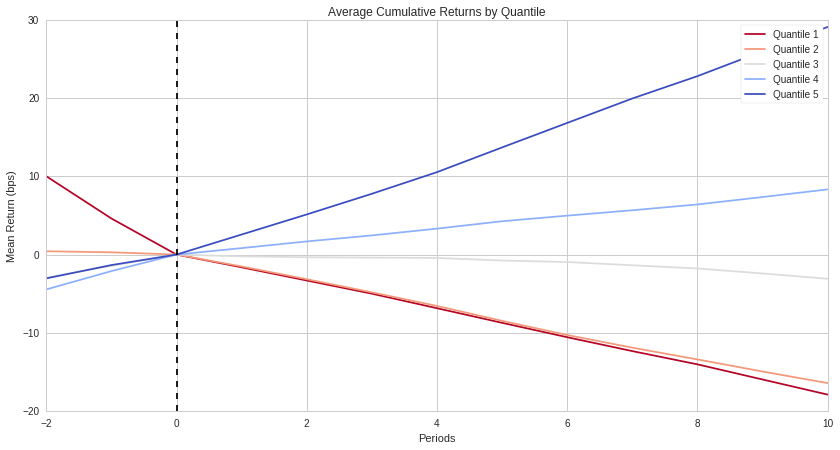

In [20]:
al.tears.create_event_returns_tear_sheet(factor_data, prices,
                                         avgretplot=(2,10),
                                         long_short=True,
                                         group_neutral=False,
                                         std_bar=False,
                                         by_group=False)

This plot shows an overview of the factor performance few days before and few days after (`avgretplot=(2,10)`) the factor signal.  On the X axis we have the time (days before and after the signal): the vertical line at day 0 is when the signal happens (the factor computation) and we can see the quantile average returns from 2 days before to 10 days after that.

The periods we chose when we call `get_clean_factor_and_forward_returns` are the ones for which we will get more detailed information in the other parts of the factor report, but in this plot we can see an overview of the performance across the full period.

If `long_short=True` the forward returns are demeaned by the factor universe mean return, which means  the market effect is removed from the returns and we can better observe the relative performance between quantiles. This is exactly what we are interested in a long-short dollar neutral strategy.

Below we can see the absolute performance with `long_short=False`. The market influence is very clear,  the returns increase on average, independently of the quantile.

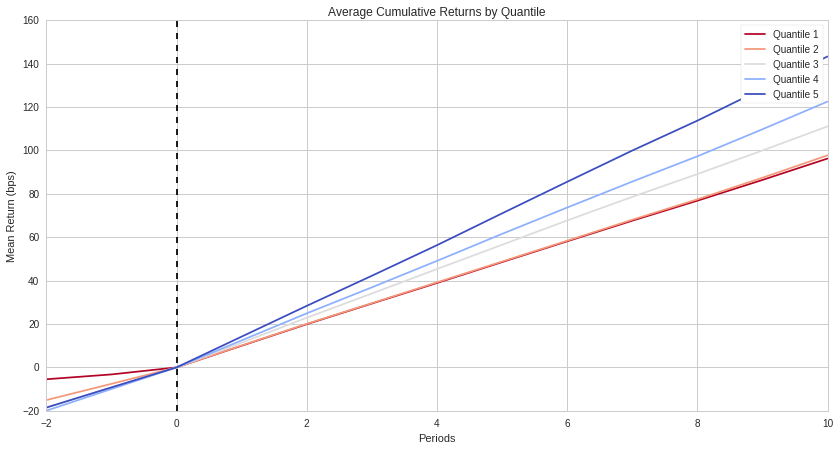

In [21]:
al.tears.create_event_returns_tear_sheet(factor_data, prices,
                                         avgretplot=(2,10),
                                         long_short=False,
                                         group_neutral=False,
                                         std_bar=False,
                                         by_group=False)

if `group_neutral=True` the quantile cumulative returns are computed separately for each group (sector), demeaned at group level and finally averaged together. This reflects what would have happened in a sector neutral strategy where for each sector the top and bottom factor values assets are selected and traded giving each sector equal weighting.

### Understanding Alphalens Report part 2: Returns Analysis

Returns Analysis


1D     5D    10D
Ann. alpha                                     0.022  0.042  0.062
beta                                           0.129  0.084  0.029
Mean Period Wise Return Top Quantile (bps)     2.585  2.762  2.951
Mean Period Wise Return Bottom Quantile (bps) -1.644 -1.755 -1.810
Mean Period Wise Spread (bps)                  4.214  4.489  4.713

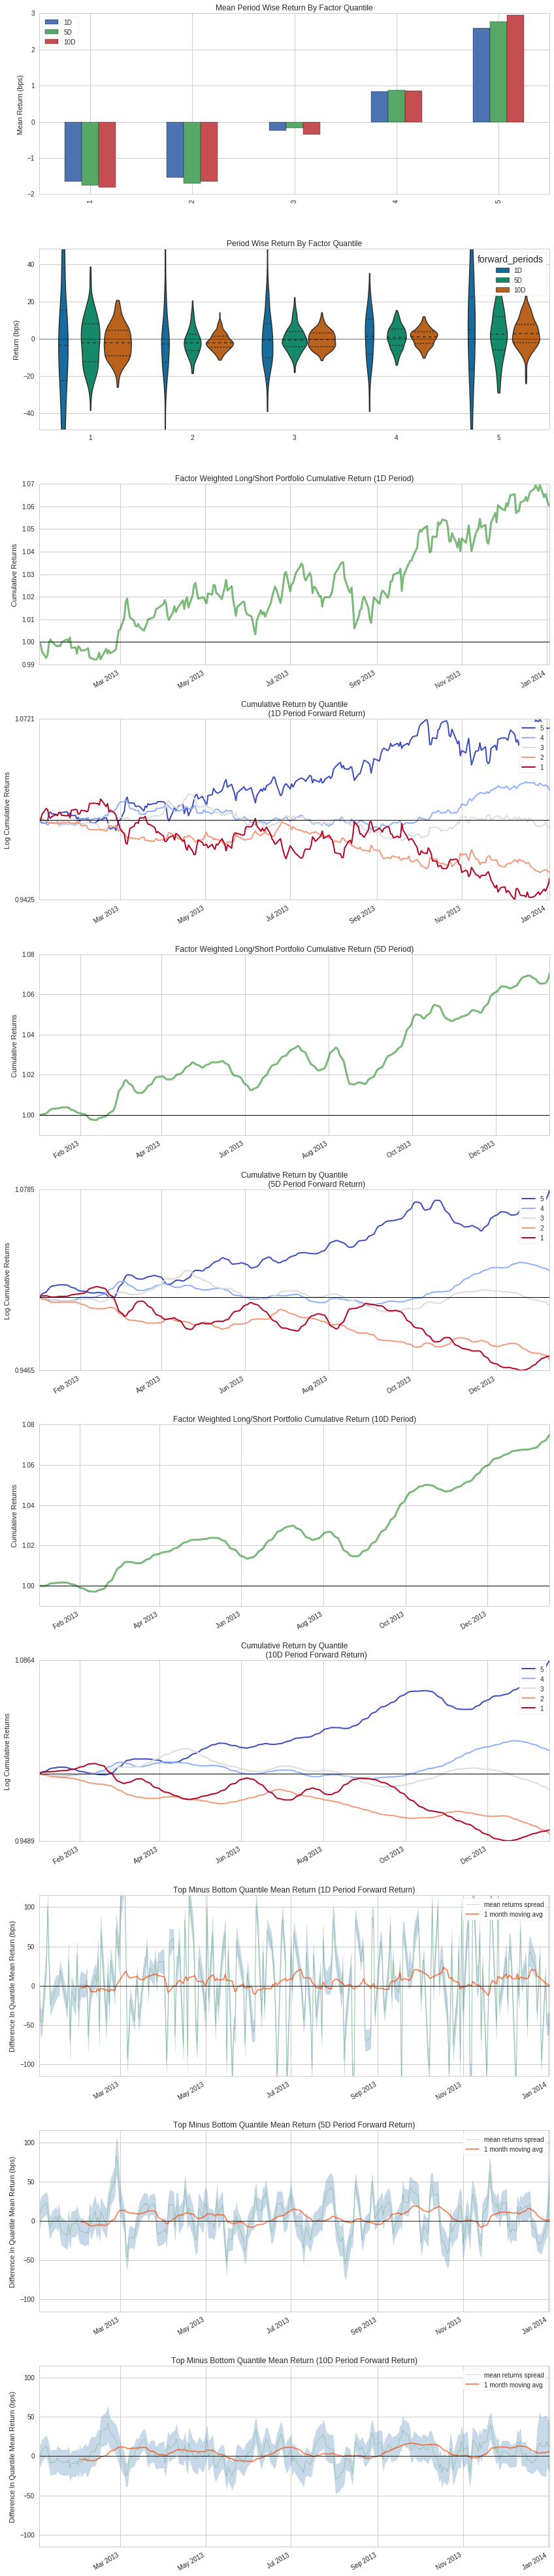

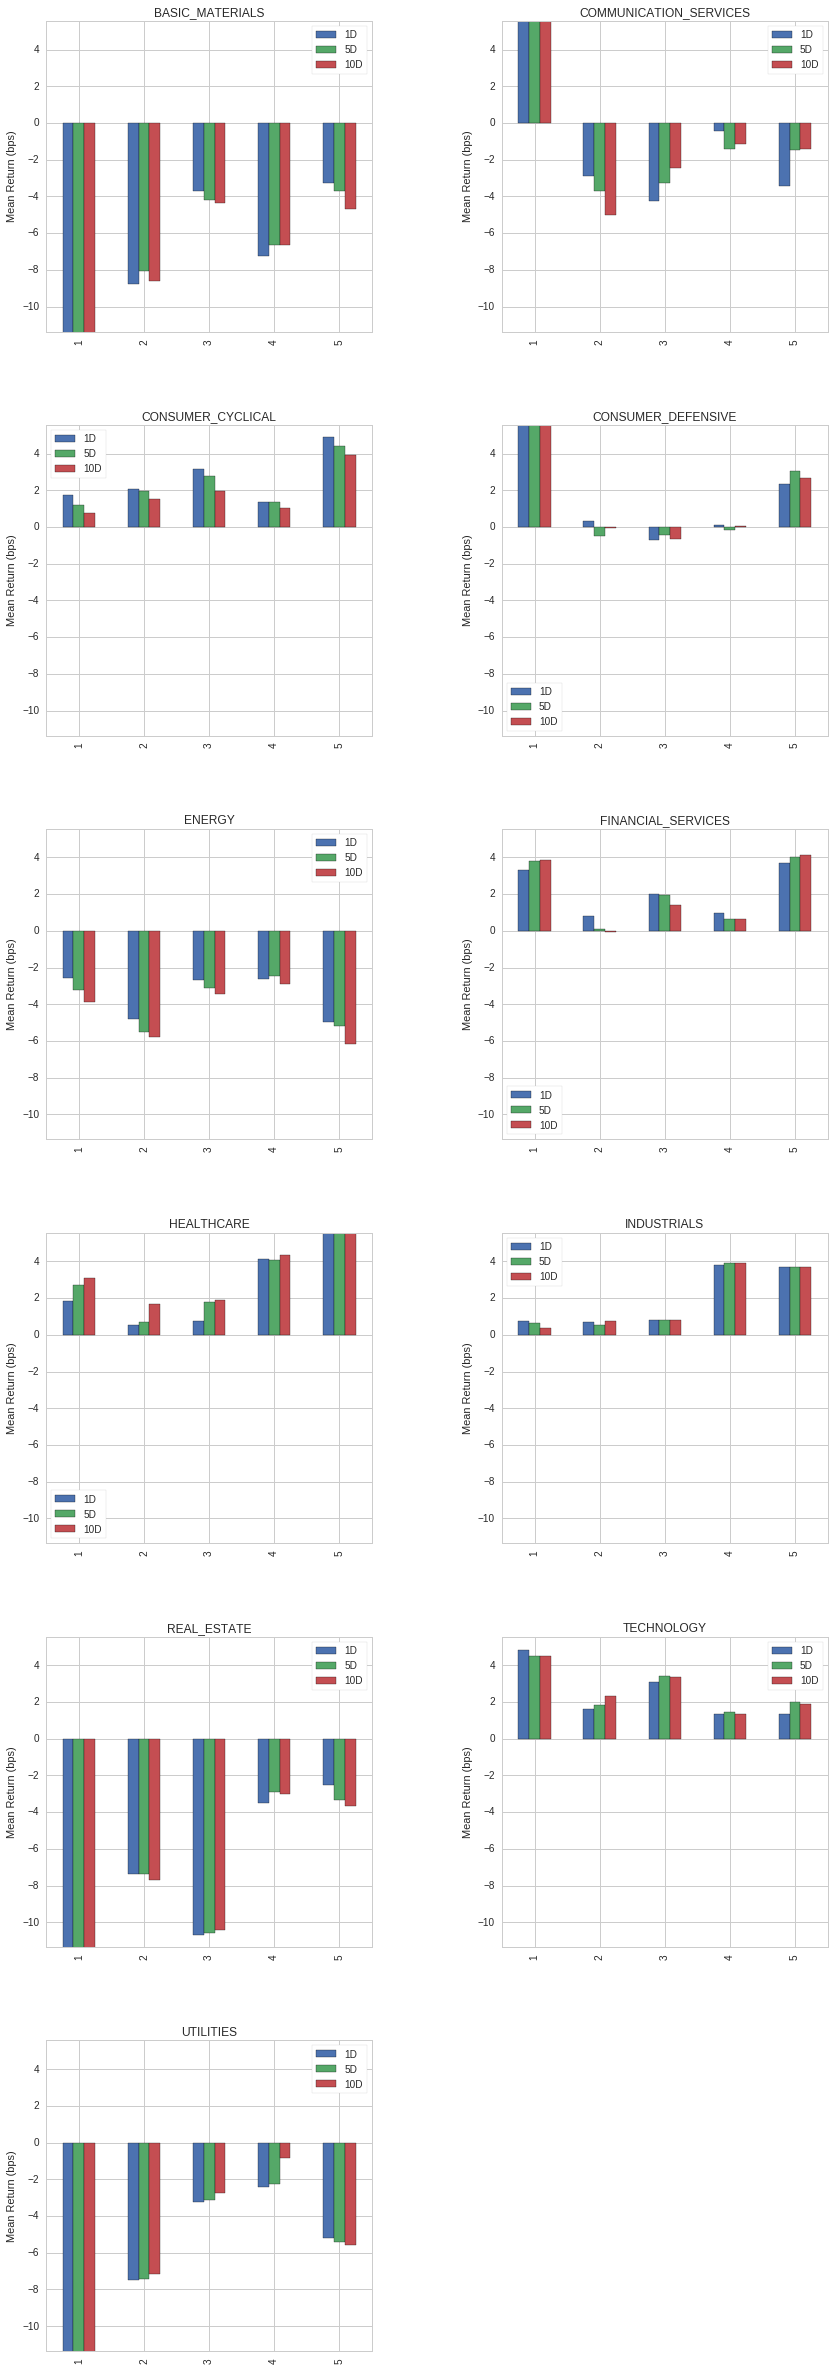

In [22]:
al.tears.create_returns_tear_sheet(factor_data,
                                   long_short=True,
                                   group_neutral=False,
                                   by_group=True)

#### Mean Period Wise Return by Factor Quantile

This plot is generated computing the mean forward return of each quantile, each day independently and averaging them at the end. This plot is telling us what return we would have made on average if we had held a specific quantile (the full stocks belonging to that quantile) for 1, 5 or 10 days or, put it in another way, what return do I get 1, 5 or 10 days in future based on factor information I know today. In this plot there are actually two different points in time: the present is the X axis, which defines the quantiles and is an information available at trading time, and the future is the Y axis, the mean forward return that a specific quantile generates on average. This latter information is not know at trading decision time, but if a factor has proven to be consistent in the past there is a good chance it keeps performing well.

What defines a predictive factor in a long-short strategy is the spread between the top and bottom quantiles. More precisely we want to see the stocks in the bottom quantiles to have negative returns and the stocks in the upper quantiles ot have positive returns. This makes sense because in a long-short strategy we long the top stocks and short the bottom ones.

Another interesting aspect of the plot is that we can see the mean returns for different periods side by side and compare them. This makes clear how long for we have to hold the securities to maximize the returns. There is a subtlety that is worth mention, though. We cannot directly compare the the 1 day mean return to 5 days (or any other days) mean return. To make sensible the comparison between different periods Alphalens shows the rate of returns. The rate of return is the value the returns would have been every day if they had grown at a steady rate. Alphalens uses the shortest period length as the base time frequency over which computing the rate of returns. So, for example, if we had 1, 5, and 10 days periods Alphalens would compute 1 day rate of retuns for all the periods and if we had 10 and 30 days (or minutes) as periods Alphalens would compute 10 days (or minutes) rate of returns. 

If `long_short=True` the forward returns are demeaned by the factor universe mean return, which results in a vertical shift of the plot (the Y axis), so that all the quantiles are centered around 0 (which represents the market). That makes easier to evaluate quantiles relative performance but the plots make sense only if the factor is traded in a dollar neutral strategy. If you plan to trade the factor in a long only strategy, then you want to set `long_short=False` to see the actual absolute performance of the quantiles.

if `group_neutral=True` is similar to `long_short` option expect the forward returns are  demeaned at group level.

#### Period Wise Return by Factor Quantile (Violin plots)

The explanation from the above plot applies to this plot too except that this plot shows the full distribution of quantile forward returns  instead of computing the mean. Looking at the variance of daily return distribution we can have a sense of how noisy our factor is.  Averaging and reducing data is useful because it allows to evaluate and quantify large amount of data but it is also good to have a sense of the reality, what kind of data we are dealing with.

#### Factor weighted Long/Short Portfolio Cumulative Return

This plot simulates what a portfolio would have returned if we had traded the full stock universe using the factor values as position weights. There is no concept of quantiles in this plot.

Even though a real strategy would trade only the top and bottom quantiles and not the full factor, with improved performance, this plot gives a sense of how predictive the factor is as a whole; the more consistent the factor is across the full universe the more this plot shows good results. The more consistency we see in this plot the more likely we trust the factor in explaining the stock returns. Also if the factor is consistent across the universe we probably want to weigh the portfolio positions by factor value, as opposite to an equal weighting scheme.

How are weights computed in the plot?

If `long_short=True` the assets weights are computed by demeaning factor values by mean factor universe and dividing by the sum of their absolute value (achieving gross leverage of 1).
If `long_short=False` the assets weights are computed dividing the factor values by the sum of their absolute value (achieving gross leverage of 1). Positive factor values will generate long positions and  negative factor values will produce short positions so that a factor with only positive values will result in a long only portfolio.

if `group_neutral=True` simulates a group neutral portfolio: the portfolio weights are computed so that each group will weigh the same, the factor values demeaning occurs on the group level resulting in a dollar neutral, group neutral,  long-short portfolio.

#### Cumulative Return By Quantile

Similarly to the previous plot we are here looking at cumulative return but this time each quantile is considered on its own and the cumulative return are computed from the quantile daily mean returns, so each asset in the quantile weigh the same.

This plot is particularly useful to check if the factor is robust in sorting performance across the quantiles. What we want to see is the top quantiles increasing in value and the bottom quantiles decreasing in value and the relative performance should be in accordance with quantile number: monotonically increase in performance for the top half quantiles and monotonically decrease in performance for the bottom half quantiles.

Another interesting aspect of this plot is that we can see the actual performance of the top and bottom  quantiles individually. Since this is the way the factor would actually be traded in a strategy (top quantile will be the long leg and bottom quantile the short leg) we can see the performance of the long and short leg of the strategy.

If long_short=True the forward returns are demeaned by the factor universe mean return, which means the market effect is removed from the returns and we can better observe the relative performance between quantiles that is exactly what we are interested in a long-short dollar neutral strategy.

if `group_neutral=True` is similar to `long_short` option expect the forward returns are  demeaned at group level.

#### Note on cumulative return plots

Here is a note regarding the cumulative returns computation in Alphalens. 

Since we are computing the factor daily, via Pipeline, if period is greater than 1 day the returns happening on one day overlap the returns happening the following days, this is because new daily factor values are computed before the previous returns are realized. if we have new factor values  but we haven’t exited the previous positions yet, how can we trade the new factor values? 

Let’s consider for example a 5 days period. A first solution could be to trade the factor every 5 days instead of daily. Unfortunately this approach has several drawbacks. One is that depending on the starting day of the algorithm we get different results, but the most important issue comes from [The Fundamental Law of Asset Management](https://www.quantopian.com/lectures/why-you-should-hedge-beta-and-sector-exposures-part-i) which states:

IR = IC √BR

The more independent bets we make the higher IR we get. In a year we have 252 trading days, if we rebalance every 5 days we have 252/5= ~50 bets instead of 252. We don't really want to decrease our performance decreasing the bets, so here is the solution:

Given a period N, the cumulative returns are computed building and averaging N interleaved sub portfolios (each started at subsequent periods 1,2,..,N) each one rebalancing every N periods and each trading 1/Nth of the initial capital. This corresponds to an algorithm which split its initial capital in N sub capitals and trades each sub capital independently, each one rebalancing every N  days. Since the sub portfolios are started in subsequent days the algorithm trades every single day. 

Compared to an algorithm that trades the factor every N day, this method increases the IR , has lower volatility, the returns are independent from the starting day and, very important, the algorithm capacity is increased by N times since the capital is split between N subportfolios and the slippage impact is decreased by N.

For more details see `help(al.performance.cumulative_returns)`

#### Top Minus Bottom Quantile Mean Return

Since in a real strategy we are interested in trading only the top and bottom quantiles and not the full factor, we can see in this plot the daily returns computed as the spread between the long and short quantile. This highlights very clearly the drawdown periods, where the plot is under 0, from the periods of positive returns. The shaded blue area illustrates an error band around the mean top minus bottom quantile returns. By default, the error band is one standard deviation above/below.

### Understanding Alphalens Report part 3: Information Coefficient Analysis

Information Analysis


1D     5D    10D
IC Mean           0.016  0.027  0.035
IC Std.           0.118  0.107  0.084
Risk-Adjusted IC  0.140  0.248  0.420
t-stat(IC)        2.230  3.951  6.685
p-value(IC)       0.027  0.000  0.000
IC Skew          -0.058  0.229  0.365
IC Kurtosis      -0.240  0.110 -0.019

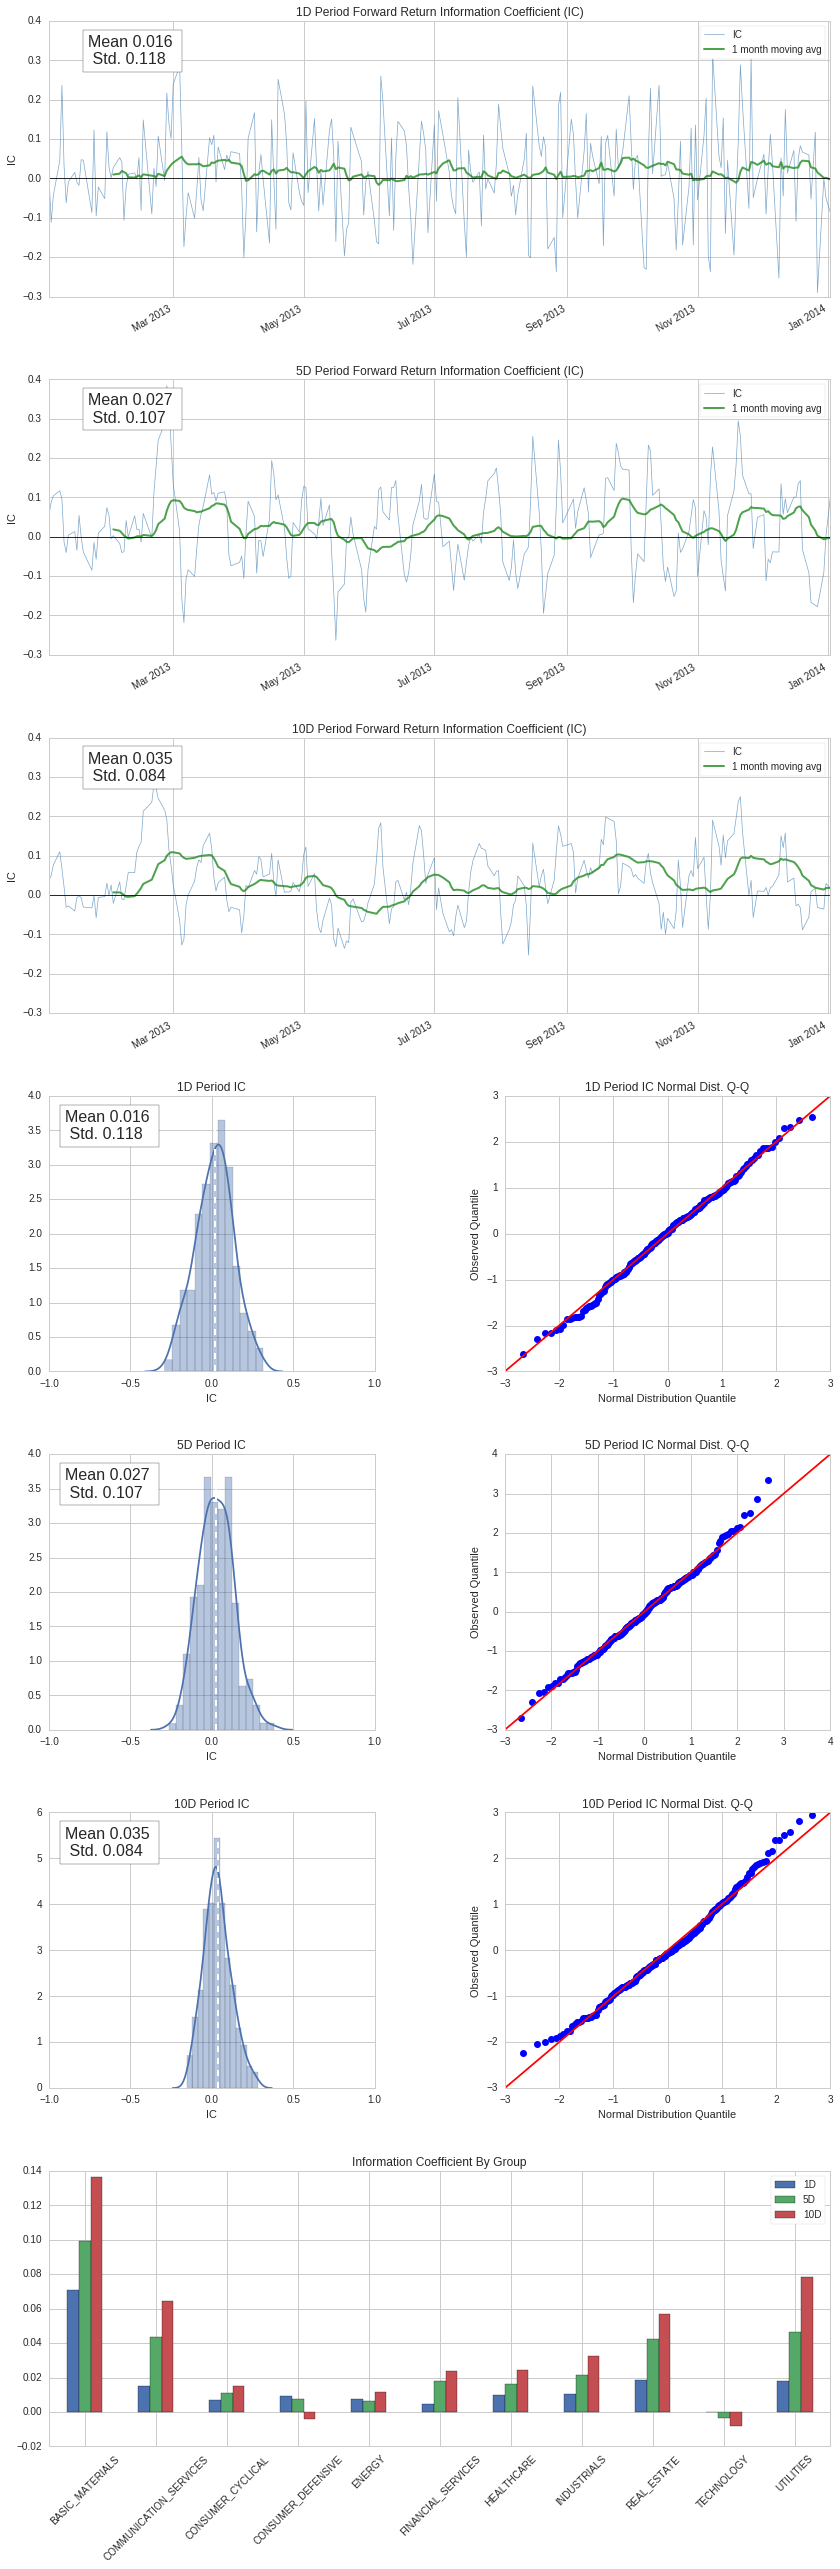

In [23]:
al.tears.create_information_tear_sheet(factor_data,
                                       group_neutral=False,
                                       by_group=True)

#### Forward Return Information Coefficient

Information Coefficient is another way at looking at a factor predictivity. The IC is computed as the [Spearman Rank Correlation](https://www.quantopian.com/lectures/spearman-rank-correlation) between factor values and forward returns. In this plot we can see the rolling correlation between the factor and the forward returns. 

The IC gives information on how well the factor sorts stocks across the whole distribution of data relatively to future returns. If we have an IC of 1 it means the relative order of factor values, the rank, is the same as the future returns, while -1 is the opposite. So the IC tells us how well the order in the factor values is kept in the future returns.  The IC is interesting because in a long-short strategy what matters is the relative performance among the stocks.

Positive IC values between 0.1 and 0.3 are good ones, as long as they are consistent in time.


#### Information Coefficient Distributions (Histogram and Q-Q plot)

This is just another way of looking at the IC shown in the previous plot. Different ways of presenting the data highlights different features.

In the histogram plots we see the daily IC distribution, which makes easy to check for consistency over time. We would like to see a positive mean IC and above the standard deviation.

The QQ plot compares the distribution of the IC to the normal distribution. This is useful for assessing if the IC is normally distributed or not. If the factor is predictive the IC distribution can't be normally distributed, what we want to see here is an S-shaped curve. This indicates that the tails of the IC distribution are fatter and contain more information.

### Understanding Alphalens Report part 4: Turnover Analysis

Turnover Analysis


10D     1D     5D
Quantile 1 Mean Turnover   0.072  0.008  0.037
Quantile 2 Mean Turnover   0.161  0.018  0.082
Quantile 3 Mean Turnover   0.188  0.021  0.097
Quantile 4 Mean Turnover   0.160  0.018  0.082
Quantile 5 Mean Turnover   0.077  0.008  0.039

1D     5D    10D
Mean Factor Rank Autocorrelation  1.0  0.998  0.991

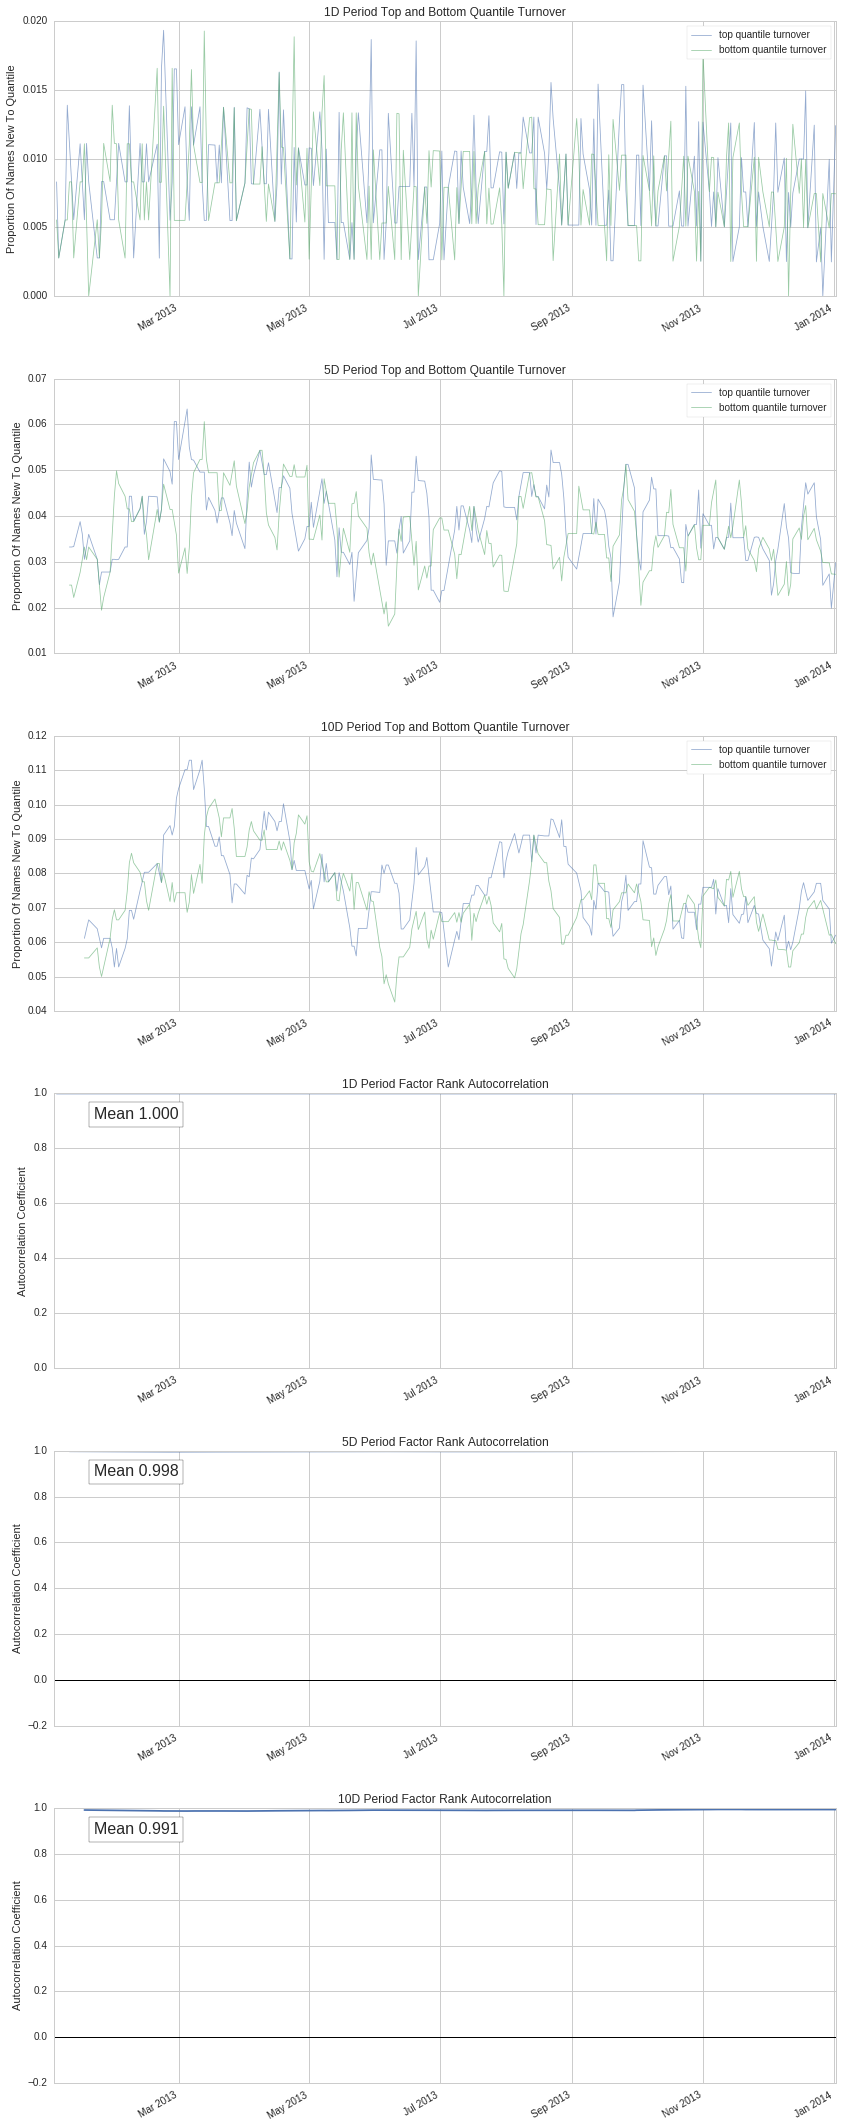

In [24]:
al.tears.create_turnover_tear_sheet(factor_data)

#### Top And Bottom Quantile Turnover

In this plot is is shown the proportion of names in a factor quantile that were not in that quantile in the previous period.
               
When considering the impact of actually implementing a signal in a strategy, turnover is a critical thing to consider. This plot shows the turnover of the top and bottom quantiles of your factor, the baskets that you would actually be trading on with a long-short approach. Excessive turnover will eat away at the profits of your strategy through commission costs.


#### Factor Rank Autocorrelation

Factor autocorrelation is the measure of correlation between the current factor value rank and its previous value. The idea behind its calculation is to provide another measure of the turnover of the factor quantiles. If the autocorrelation is low, it implies that the current value of the factor has little to do with the previous value and that portfolio positions are changing frequently from time period to time period. If the next value of the factor is significantly influenced by its last value, this means that your ranking scheme is more consistent (though this has no influence on its ability to forecast relative price movements).

# Running Pyfolio from Alphalens

## Portfolio analysis

Alphalens can simulate the performance of a portfolio built using the factor values as assets weights. The result of this simulation can then be be analyzed by Pyfolio. The function we use to simulate the portfolio is:

In [ ]:
al.performance.create_pyfolio_input(factor_data,
                                    period,
                                    capital=None,
                                    long_short=True,
                                    group_neutral=False,
                                    equal_weight=False,
                                    quantiles=None,
                                    groups=None,
                                    benchmark_period='1D')

It has many options that influence the portfolio simulation and you can view their details with  `help(al.performance.create_pyfolio_input)`.  Here we provide a summary:

- `period` : 'period' returns to be used in the computation of the porfolio. The period must be one of the periods computed by al.utils.get_clean_factor_and_forward_returns.

- `capital` : capital used in the simulation. This doesn't have much of an impact, it is used to scale the assets weigthts to an actual dollar value. This is required by Pyfolio.

- `long_short` and `group_neutral` :  those option work accordingly to what we saw in the Alphalens return analysis.  `long_short` is used to simulate a dollar neutral long-short portfolio and `group_neutral` to simulate a group neutral portfolio (provided that the group information is present in `factor_data`).

- `equal_weight` : if True the assets will be equal-weighted otherwise they will be factor-weighed

- `quantiles`: select specific quantiles to be used in the computation. By default all quantiles are used

- `groups`: select specific groups to be used in the computation. By default all groups are used

Using those options we can mimic the performance we saw in the "Factor weighted Portfolio Cumulative Return" plot. To do so we have to set set `equal_weight=False` (factor weighted insted of equal weighting), `quantiles=None` (use all quantiles) and `groups=None` (use all groups).

Now let's try that. Since we saw in Alphalens report that quantiles 1 and 5 are the most predictive, we'll simulate  a portfolio where only those quantiles are traded.

In [25]:
pf_returns, pf_positions, pf_benchmark = \
    al.performance.create_pyfolio_input(factor_data,
                                        period='5D',
                                        capital=1000000,
                                        long_short=True,
                                        group_neutral=False,
                                        equal_weight=True,
                                        quantiles=[1,5],
                                        groups=None,
                                        benchmark_period='1D')

As we can see, the benchmark returns are returned as well. Benchmark returns are computed as the factor universe mean returns traded at 'benchmark_period' frequency. This benchmark can be passed to pyfolio, which prevent it from using the default benchmark SPY. This might be useful to compare the strategy performance with the performance of the universe you are actually using, instead of relying on SPY.
        
Now that we have prepared the data we can run Pyfolio functions

In [26]:
import pyfolio as pf

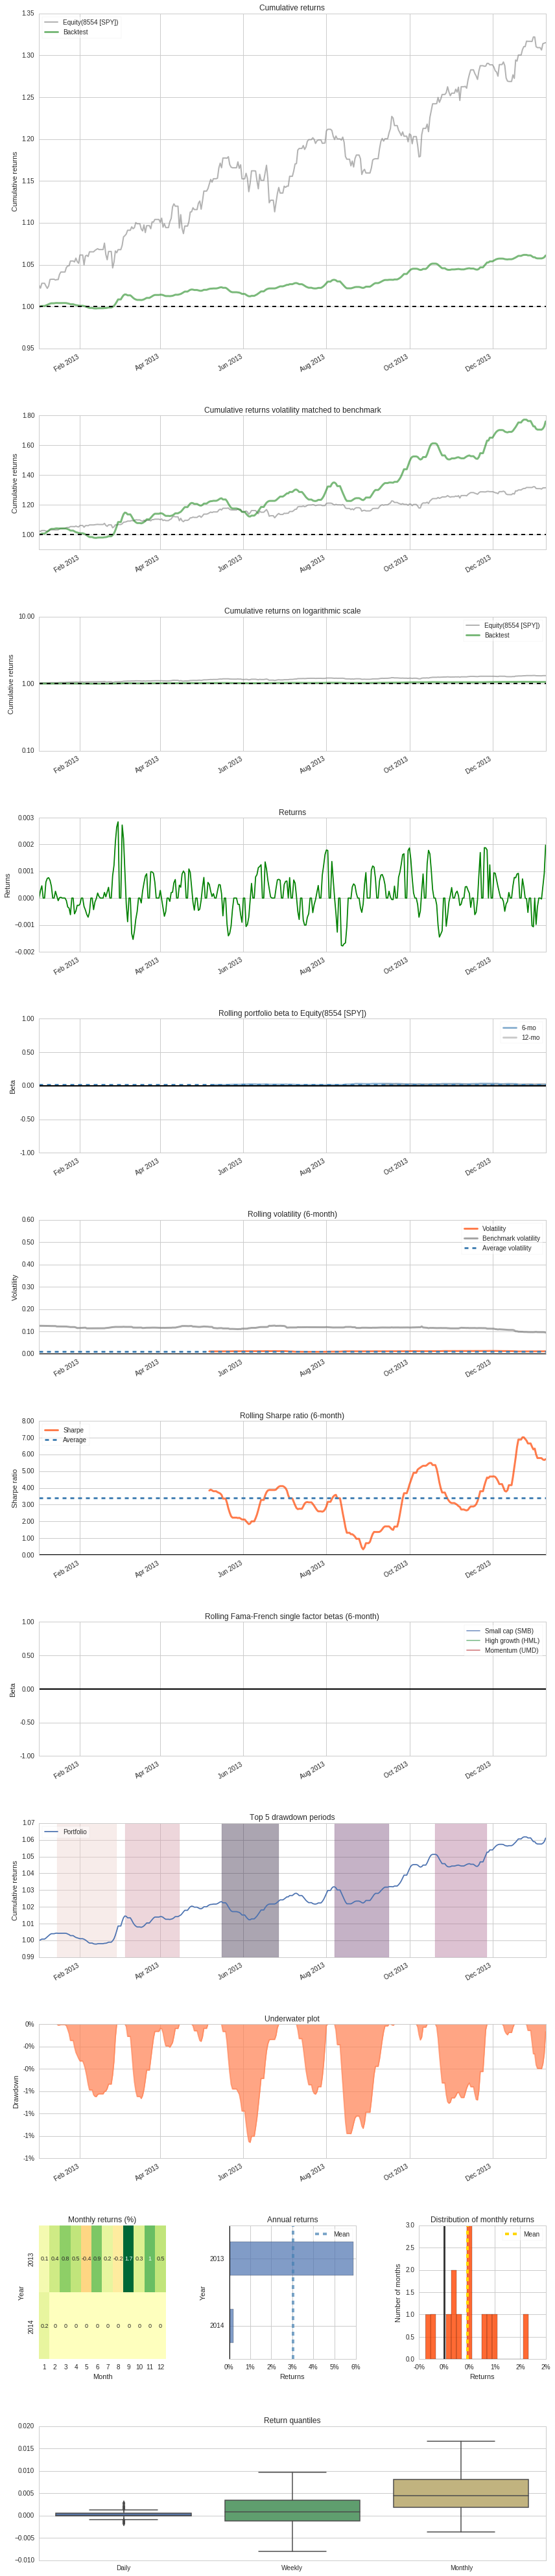

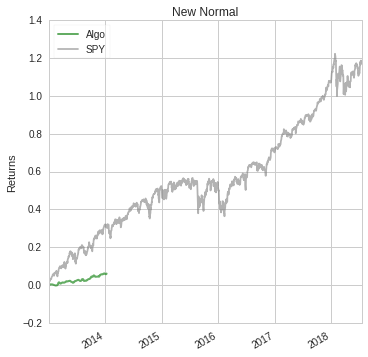

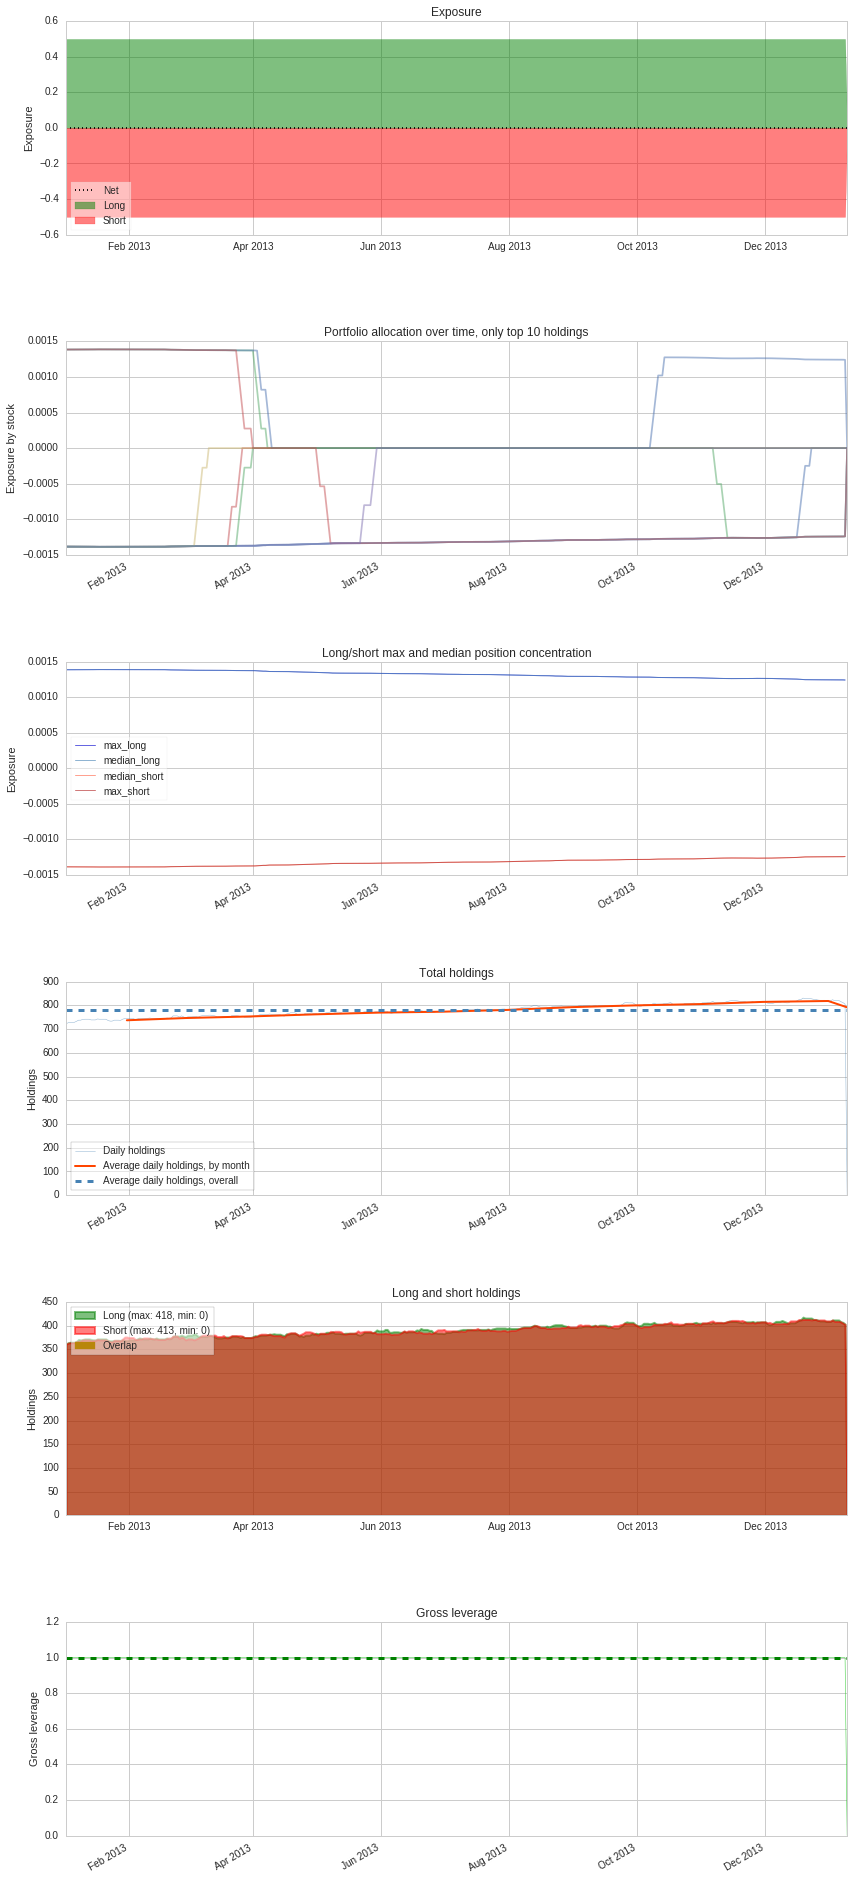

In [27]:
pf.tears.create_full_tear_sheet(pf_returns,
                                positions=pf_positions,
                                #benchmark_rets=pf_benchmark, # optional, default to SPY
                                hide_positions=True)

###  Risk Exposure

Once you have found a predictive factor you want to take into consideration the risk associated with it and Quantopian provides a [risk model](https://www.quantopian.com/posts/introduction-to-the-quantopian-risk-model-in-research) that helps you with this analysis.

To perform the risk analysis we need to load the factor loadings and returns associated with the assets  in the traded universe.

In [28]:
from quantopian.research.experimental import get_factor_loadings, get_factor_returns

In [29]:
asset_list = factor_data.index.levels[1].unique()
start_date = factor_data.index.levels[0].min()
end_date   = factor_data.index.levels[0].max()

factor_loadings = get_factor_loadings(asset_list, start_date, end_date)
factor_returns = get_factor_returns(start_date, end_date)

Pyfolio expects factor_loadings to have specific index names

In [30]:
factor_loadings.index.names = ['dt', 'ticker']

/usr/local/lib/python2.7/dist-packages/pyfolio/perf_attrib.py:589: UserWarning: Could not find factor loadings for 120 dates: (first missing is 2013-01-05 00:00:00+00:00, last missing is 2014-01-09 00:00:00+00:00). Truncating date range for performance attribution. 
  warnings.warn(warning_msg)


## Performance Relative to Common Risk Factors

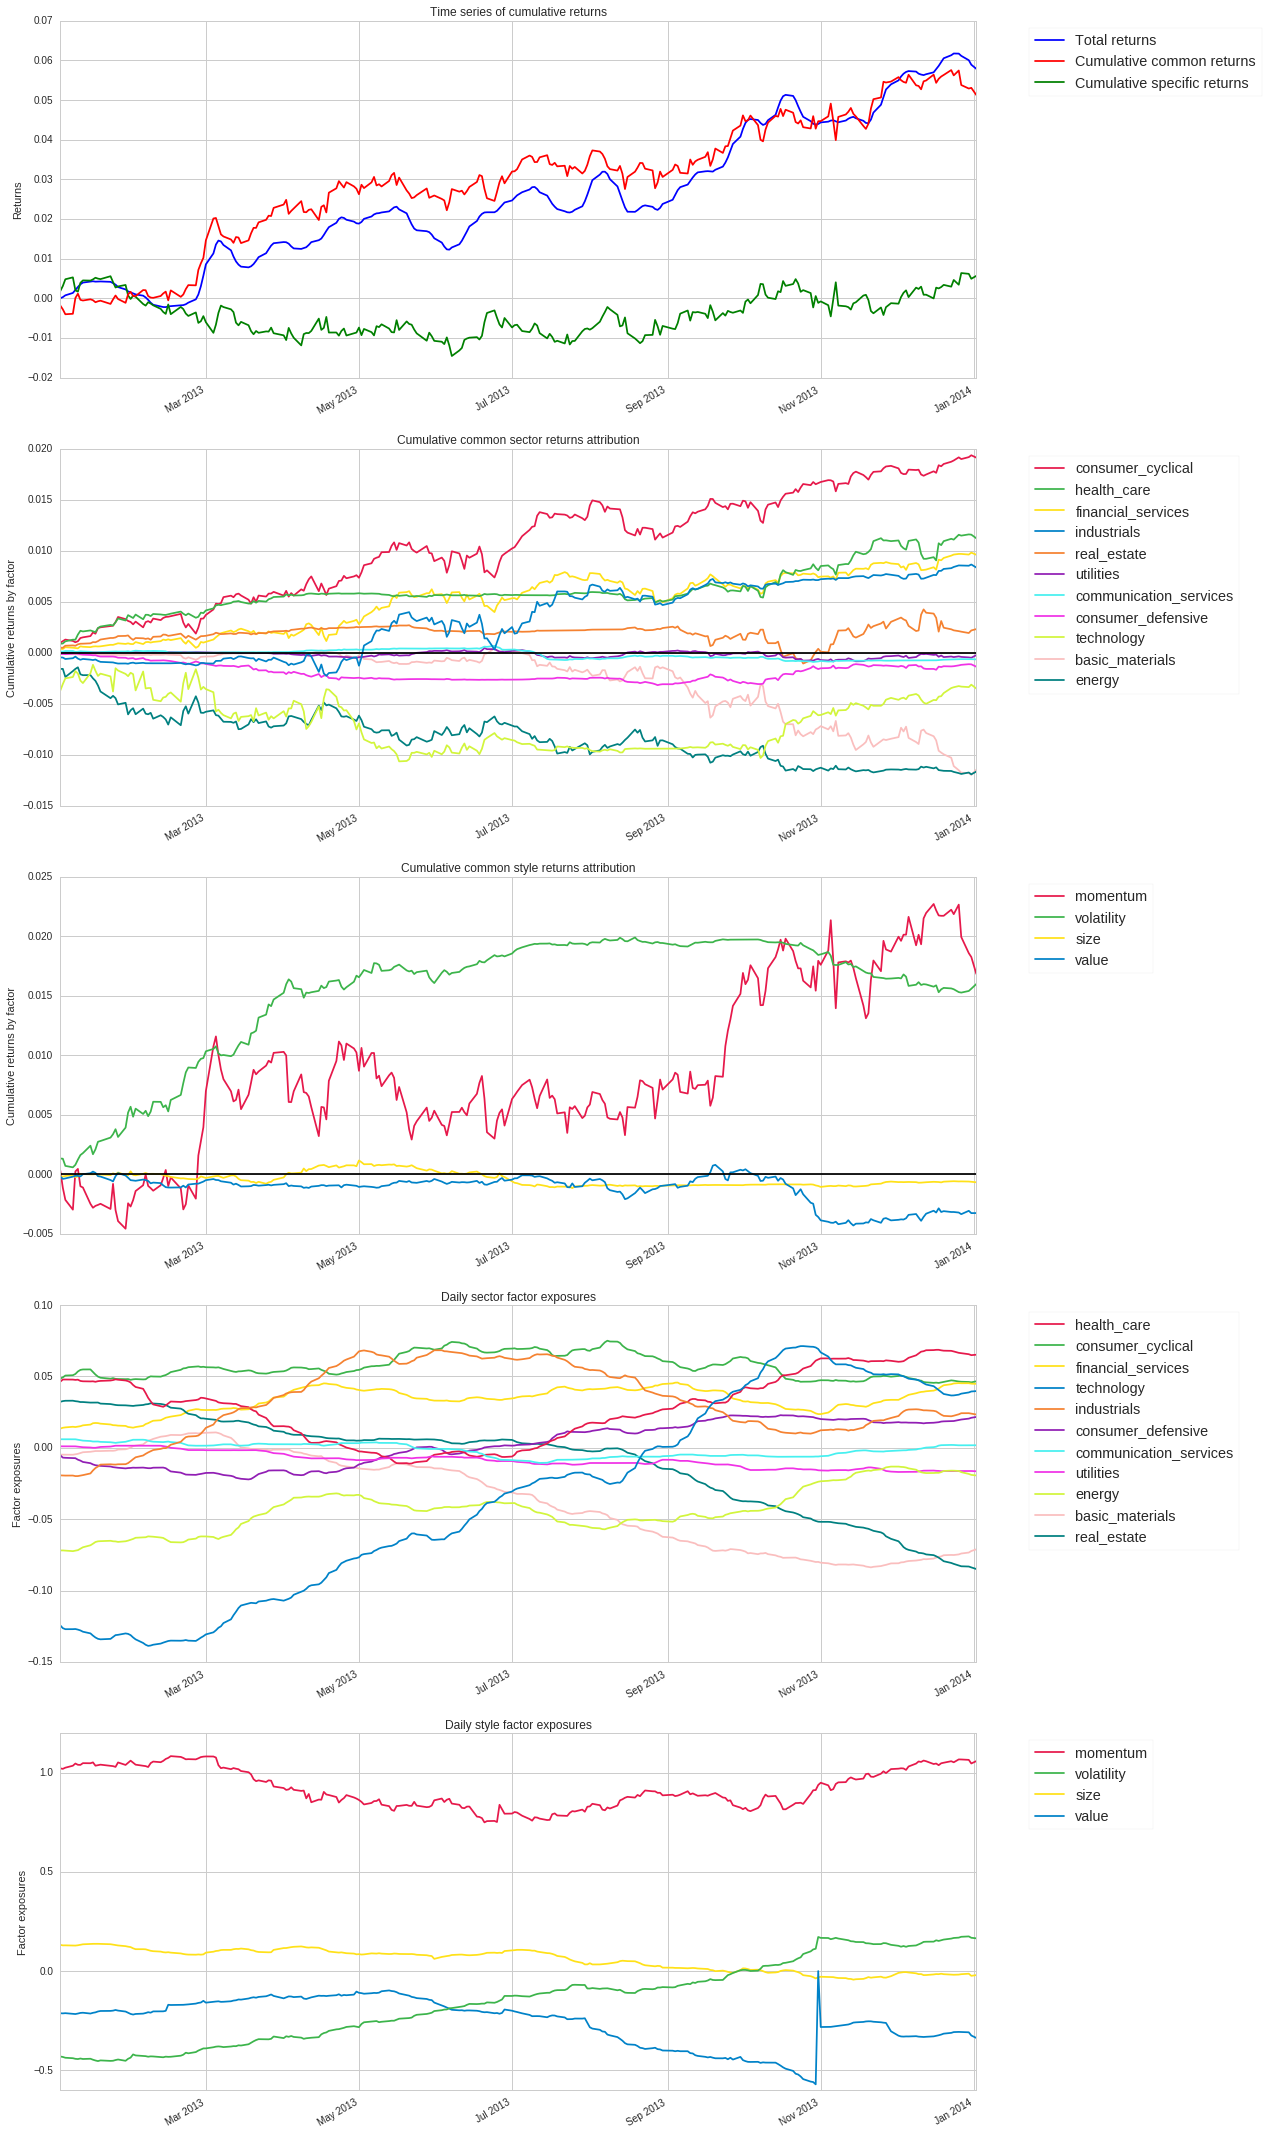

In [31]:
pf.tears.create_perf_attrib_tear_sheet(pf_returns,
                                       positions=pf_positions,
                                       factor_returns=factor_returns,
                                       factor_loadings=factor_loadings,      
                                       pos_in_dollars=True)

# Adavanced topics

## More on quantiles

Let's go back to the the data preparation stage and dig into the details of quantiles generation.

First let's have a look at the quantiles information we used in the Momentum factor analysis:

In [32]:
al.plotting.plot_quantile_statistics_table(factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.010408  0.000293 -0.000929  0.001145  95950  20.021367
2               -0.000619  0.000857  0.000387  0.000312  95797  19.989442
3                0.000044  0.001380  0.000888  0.000300  95800  19.990068
4                0.000501  0.002120  0.001406  0.000354  95797  19.989442
5                0.001015  0.011105  0.002657  0.001147  95894  20.009682

We can see from `amount` column that each quantile contains an equal amount of entries, but it is also possible to create non-equal-sized buckets. We can do so by passing a custom sequence of quantiles, e.g. `quantiles=[0, .05, .30, .50, .70, .95, 1.00]`. This might be useful if we suspect the factor doesn't perform equally well across all the values, e.g. we  might want to analyze in a separate quantile the extreme top/bottom value, suspecting for a strange behaviour of the outliers.

In [33]:
alternative_binning_factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=factors["MyFactor"],
    prices=prices,
    quantiles=[0, .05, .30, .50, .70, .95, 1.00],
    bins=None,
    periods=(1, 5, 10))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [34]:
al.plotting.plot_quantile_statistics_table(alternative_binning_factor_data)

Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
1               -0.010408 -0.001040 -0.002466  0.001201   24082   5.025061
2               -0.002053  0.000624 -0.000151  0.000512  119762  24.990088
3               -0.000251  0.001128  0.000651  0.000297   95844  19.999249
4                0.000291  0.001697  0.001130  0.000317   95741  19.977756
5                0.000729  0.003601  0.001936  0.000532  119752  24.988002
6                0.002053  0.011105  0.004061  0.001380   24057   5.019844

## Bins

`quantiles` option chooses the buckets to have the same number of items but it doesn't take into consideration the factor values. For this reason there is another option `bins`, which chooses the buckets to be evenly spaced according to the values themselves.

Let's have a look at RSI factor. The RSI, whose values range from 0 to 100, provides a signal that tells investors to buy when the currency is oversold and to sell when it is overbought, which it provides an indication of market reversal. The thresholds are usually set to 70 and 30, but more stringent ones may be chosen like 80/20 or 90/10.

In [35]:
from quantopian.pipeline.factors import RSI

In [36]:
pipe = Pipeline(
    columns = {
            'RSI' : RSI(mask=universe),
    },
    screen=universe
)
more_factors = run_pipeline(pipe, '2014-01-01', '2015-01-01')
asset_list = more_factors.index.levels[1].unique()
prices = get_pricing(asset_list, start_date='2014-01-01', end_date='2015-02-01', fields='open_price')

Let's see how our RSI factor reacts to the quantization:  

In [37]:
rsi_factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=more_factors["RSI"],
    prices=prices,
    quantiles=5,
    bins=None,
    periods=(1, 5, 10))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [38]:
al.plotting.plot_quantile_statistics_table(rsi_factor_data)

Quantiles Statistics


min         max       mean        std   count  \
factor_quantile                                                        
1                 0.000000   61.722488  30.666442  10.722765  107350   
2                18.994431   71.589205  43.852199   9.983730  107198   
3                26.613516   77.943332  52.063103  10.084194  107206   
4                33.404482   84.375000  60.337646   9.860922  107195   
5                42.258065  100.000000  73.280406  10.360761  107301   

                   count %  
factor_quantile             
1                20.018648  
2                19.990303  
3                19.991795  
4                19.989744  
5                20.009510

That doesn't seem right. If the quantiles are choosen irrespectively of the factor values we won't be able to analyze the signal at different thresholds. For this reason we will use the `bins` option, which allows to custom ranges too, the same as `quantiles`, but this time they are factor value based.

In [39]:
rsi_factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=more_factors["RSI"],
    prices=prices,
    quantiles=None,
    bins=[0, 10, 20, 30, 70, 80, 90, 100],
    periods=(1, 5, 10))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [40]:
al.plotting.plot_quantile_statistics_table(rsi_factor_data)

Quantiles Statistics


min    max       mean        std   count    count %
factor_quantile                                                           
1.0               0.057737   10.0   7.046049   2.308980    2529   0.471619
2.0              10.000000   20.0  16.135608   2.718775   15247   2.843327
3.0              20.000000   30.0  25.630584   2.820969   44072   8.218739
4.0              30.000000   70.0  50.625340  10.819535  384495  71.702304
5.0              70.000000   80.0  74.485046   2.845483   58715  10.949429
6.0              80.000000   90.0  84.069939   2.775390   25523   4.759640
7.0              90.000000  100.0  93.267738   2.470455    5657   1.054942

This seems a much more sensible binning for RSI, the Alphalens analysis will be able distinguish between different level of RSI signal.

## Factors with discrete values

Another issue we might have with the quantiles is when the factor provides discrete values. Let's consider Sentdex Sentiment Analysis factor, which provides signal values from -3 to a positive 6, where -3 is as equally strongly negative of sentiment as a 6 is strongly positive sentiment.

Sentiment signals:
*  6 - Strongest positive sentiment.
*  5 - Extremely strong, positive, sentiment.
*  4 - Very strong, positive, sentiment.
*  3 - Strong, positive sentiment.
*  2 - Substantially positive sentiment.
*  1 - Barely positive sentiment.
*  0 - Neutral sentiment
* -1 - Sentiment trending into negatives.
* -2 - Weak negative sentiment.
* -3 - Strongest negative sentiment.

Since the singal is provided with discrete values we don't want to use `quantiles`, which would cause to mix multiple values in a single quantile. Again we make use of `bins` option. This time we want to make sure each signal value falls in a specific bucket, so that we will be able to analyze each singal value individually.

In [41]:
from quantopian.pipeline.data.sentdex import sentiment_free

In [42]:
pipe = Pipeline(
    columns = {
            'Sentdex' : sentiment_free.sentiment_signal.latest,
    },
    screen=universe
)
more_factors = run_pipeline(pipe, '2014-01-01', '2015-01-01')
asset_list = more_factors.index.levels[1].unique()
prices = get_pricing(asset_list, start_date='2014-01-01', end_date='2015-02-01', fields='open_price')

In [43]:
sentdex_factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=more_factors["Sentdex"],
    prices=prices,
    quantiles=None,
    bins=[-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5 ],
    periods=(1, 2, 5),
    max_loss = 0.80 ) # allow 80% data loss since sentdex is not available for the full QTradableStocksUS

Dropped 75.3% entries from factor data: 75.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 80.0%, not exceeded: OK!


In [44]:
al.plotting.plot_quantile_statistics_table(sentdex_factor_data)

Quantiles Statistics


min  max  mean  std  count    count %
factor_quantile                                       
1               -3.0 -3.0  -3.0  0.0  11337   8.542365
3               -1.0 -1.0  -1.0  0.0  36505  27.506311
5                1.0  1.0   1.0  0.0  14669  11.053008
6                2.0  2.0   2.0  0.0  23178  17.464492
7                3.0  3.0   3.0  0.0   8717   6.568210
8                4.0  4.0   4.0  0.0   8181   6.164337
9                5.0  5.0   5.0  0.0   8544   6.437856
10               6.0  6.0   6.0  0.0  21584  16.263422

We can see that each signal value falls in a specific bucket.

## More on Groups Breakdown

We have already seen how the sector information allows to analyze how the factor performs across different sectors but the group breakdown feature can also be used with many other interesting groups. For example we could analyze how volatility, momentum, beta, market cap, book-to-price ratios  affect the factor performance. Doing so is straightforward: we need to compute those values via Pipeline, the same way we did with sectors and then pass this information to 'get_clean_factor_and_forward_returns'. There is only one caveat: sectors data has discrete values while other groups might not, so we need a way to discretize contiguous data values. To achieve that we can use the 'quantiles()' [factor method](https://www.quantopian.com/help#quantopian_pipeline_factors_Factor) to create quantiles from the factor values.

In [45]:
from quantopian.pipeline.factors import SimpleBeta, Returns
from quantopian.pipeline.data import Fundamentals

class Volatility(CustomFactor):
    inputs = [Returns(window_length=126)]
    window_length = 252
    def compute(self, today, assets, out, returns):
        out[:] = np.nanstd(returns, axis=0)
        
class Momentum(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 252
    def compute(self, today, assets, out, prices):
        start = self.window_length
        out[:] = (prices[0] - prices[-start])/prices[-start]

In [46]:
market = symbols('SPY')

number_of_groups = 6

pipe = Pipeline(
    columns = {
            'market_cap' : Fundamentals.market_cap.latest.quantiles(number_of_groups),
            'B_to_M'     : Fundamentals.book_value_yield.latest.quantiles(number_of_groups),
            'Volatility' : Volatility(mask=universe).quantiles(number_of_groups),
            'Beta'       : SimpleBeta(market, 252).quantiles(number_of_groups),
            'Momentum'   : Momentum(mask=universe).quantiles(number_of_groups),
    },
    screen=universe
)

At this point we can pass any of those groups to 'get_clean_factor_and_forward_returns', for example:

    factor_data = al.utils.get_clean_factor_and_forward_returns(
        [...]
        groupby=factors["Beta"],    # use any of market_cap, B_to_M, Volatility, Beta, Momentum
        [...]    

### Binning By Group

When the factor value distributions vary considerably between groups, so much that certain groups values fall within few quantiles instead of the full range, it is wise to perform a group relative binning. This is available via `binning_by_group` (`get_clean_factor_and_forward_returns` argument): if True,  buckets are computed separately for each group. You should really enable this option especially if the factor is intended to be analyzed for a group neutral portfolio.

## Intraday analysis

Alphalens is not limited to daily frequency analysis, there is no assumption in the factor or price frequency. If we use Pipeline to compute factors we are restricted daily frequency, but we don't have restrictions on price  so we'll see how we can compute intraday price information for the Momentum factor ([here](https://www.quantopian.com/posts/researching-intraday-factors-with-alphalens-overnight-price-gap-example) you can find an example of intraday analysis without Pipeline)

It would be possible to simply load the full price information using get_pricing and minute resolution but that requires lots of memory, so we'll load the data day by day instead and keep only the prices we are interested in and discarding the rest.

Loading the price day by day has a side effect though: split, merge and dividends will not automatically handled by `get_pricing`, instead only prices coming from the same call to `get_pricing` can be used to generate returns (which is not really a problem in this case as we are evaluating intraday returns). So, to  make the code more robust we will pass the returns to Alphalens instead of price information and this gives us the chace to see some new Alphalens utility functions too.

In [47]:
intraday_factor = factors["MyFactor"]

We have to make sure that Alphalens will match the factor data with the right price information, that is  we have to set the factor index at market open. Since Pipeline uses midnight as timestamp we have to add 9 hours and 30 minutes to the factor index.

In [48]:
intraday_factor = intraday_factor.unstack()
intraday_factor.index += pd.Timedelta('14h31m') # 14h31m is 09h31m at my current Timezone
intraday_factor = intraday_factor.stack()
intraday_factor.head()

2013-01-02 14:31:00+00:00  Equity(2 [ARNC])    -0.000726
                           Equity(24 [AAPL])    0.000940
                           Equity(31 [ABAX])    0.001594
                           Equity(39 [DDC])     0.000388
                           Equity(52 [ABM])    -0.000777
dtype: float64

We can also use the previous lines of code to set the factor index to a different time than market open and that would allow to analyze the factor performance when it is traded at a later time than market open.

In [49]:
forward_returns = []

# loop through each day in the factor DataFrame
for timestamp, daily_factor in intraday_factor.groupby(level=0):
    
    # equities in the universe at that particular day
    equities = daily_factor.index.levels[1]
    
    # we use get_pricing() with minute resolution to fetch the minute prices at that particular day
    start = timestamp
    end   = timestamp + pd.Timedelta('180m') # make sure to load enough data
    __prices = get_pricing(equities, start, end, frequency='minute', fields='price')

    if len(__prices) < 181:
        continue
        
    # use Alphalens to compute forward returns for 30m, 60m, 90m, 120m, 180m
    __forward_returns = al.utils.compute_forward_returns(daily_factor,
                                                         __prices,
                                                         periods=(30, 60, 90, 120, 180))
    forward_returns.append(__forward_returns)

In [50]:
forward_returns = pd.concat(forward_returns)
forward_returns.head()

30m        1h     1h30m  \
date                      asset                                             
2013-01-02 14:31:00+00:00 Equity(2 [ARNC])   0.001464  0.000563  0.000338   
                          Equity(24 [AAPL]) -0.003110 -0.007179 -0.008988   
                          Equity(31 [ABAX])  0.000000  0.000526 -0.004474   
                          Equity(39 [DDC])  -0.005614 -0.018246 -0.021754   
                          Equity(41 [ARCB])  0.020534  0.011294  0.006160   

                                                   2h        3h  
date                      asset                                  
2013-01-02 14:31:00+00:00 Equity(2 [ARNC])   0.003491  0.005631  
                          Equity(24 [AAPL]) -0.011650 -0.016312  
                          Equity(31 [ABAX]) -0.002105 -0.007105  
                          Equity(39 [DDC])  -0.019649 -0.020351  
                          Equity(41 [ARCB])  0.007187  0.003080

At this point we will call `get_clean_factor` function, which is similar to `get_clean_factor_and_forward_returns` (same purpose and same arguments), but it accepts forward returns instead of price information.

In [51]:
intraday_factor_data = al.utils.get_clean_factor(factor=intraday_factor,
                                                 forward_returns=forward_returns)

Dropped 0.4% entries from factor data: 0.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Then we continue as usual calling any of the tear sheet functions.

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.010408  0.000293 -0.000929  0.001145  95580  20.020863
2               -0.000616  0.000857  0.000386  0.000312  95427  19.988814
3                0.000044  0.001380  0.000887  0.000301  95440  19.991538
4                0.000501  0.002120  0.001406  0.000354  95427  19.988814
5                0.001015  0.011105  0.002657  0.001147  95528  20.009971

Returns Analysis


30m     1h  1h30m     2h  \
Ann. alpha                                    -0.355 -0.173 -0.209  0.038   
beta                                           0.181  0.217  0.208  0.194   
Mean Period Wise Return Top Quantile (bps)    -0.696 -0.423 -0.292 -0.065   
Mean Period Wise Return Bottom Quantile (bps) -0.272 -0.198 -0.102 -0.213   
Mean Period Wise Spread (bps)                 -0.365 -0.171 -0.153  0.168   

                                                  3h  
Ann. alpha                                     0.080  
beta                                           0.173  
Mean Period Wise Return Top Quantile (bps)     0.091  
Mean Period Wise Return Bottom Quantile (bps) -0.209  
Mean Period Wise Spread (bps)                  0.302

/usr/local/lib/python2.7/dist-packages/alphalens/performance.py:398: UserWarning: 'freq' not set, using business day calendar
  UserWarning)


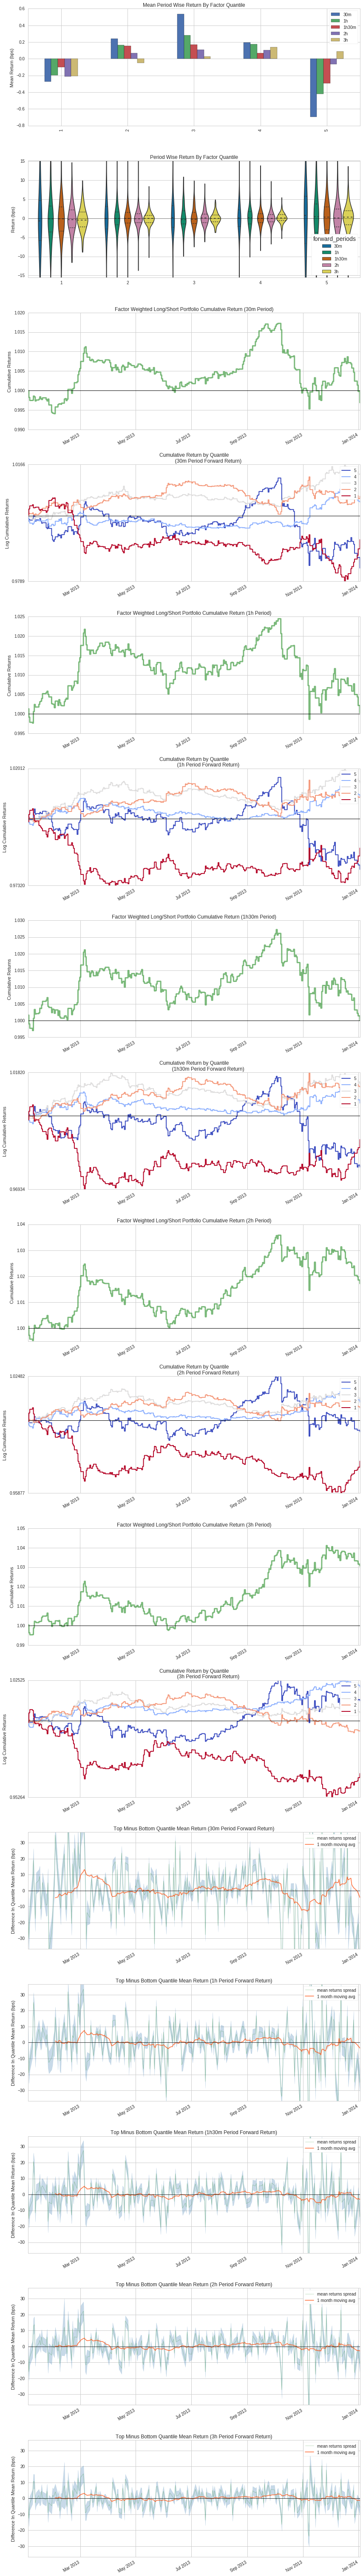

Information Analysis


30m     1h  1h30m     2h     3h
IC Mean           0.001  0.004  0.004  0.010  0.013
IC Std.           0.099  0.111  0.112  0.112  0.116
Risk-Adjusted IC  0.010  0.039  0.037  0.086  0.111
t-stat(IC)        0.164  0.626  0.580  1.359  1.768
p-value(IC)       0.870  0.532  0.563  0.175  0.078
IC Skew          -0.262 -0.268 -0.148 -0.139 -0.123
IC Kurtosis       0.609  0.971  0.557  0.586  0.182

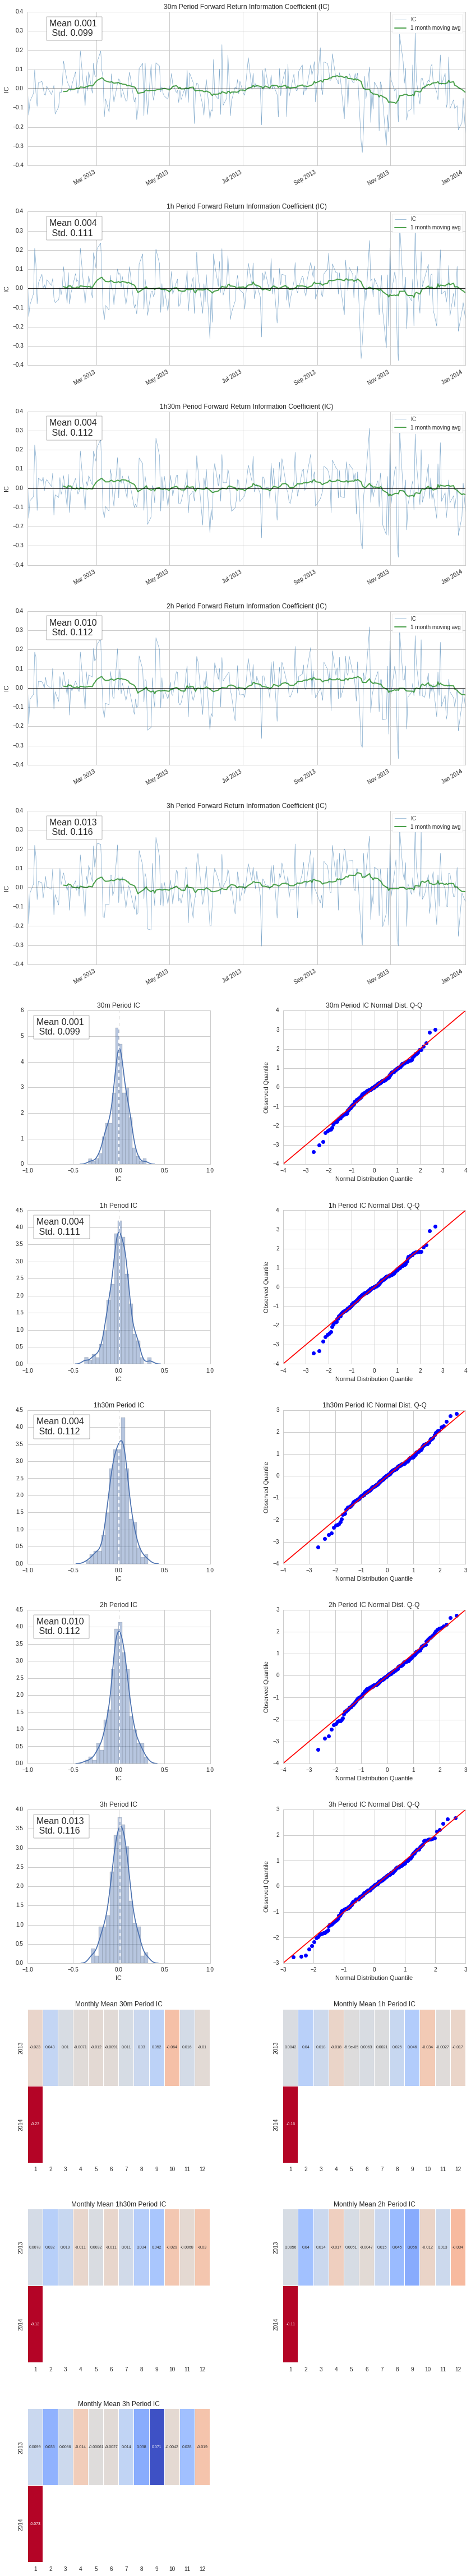

Turnover Analysis


1h  1h30m   2h  30m   3h
Quantile 1 Mean Turnover   0.0    0.0  0.0  0.0  0.0
Quantile 2 Mean Turnover   0.0    0.0  0.0  0.0  0.0
Quantile 3 Mean Turnover   0.0    0.0  0.0  0.0  0.0
Quantile 4 Mean Turnover   0.0    0.0  0.0  0.0  0.0
Quantile 5 Mean Turnover   0.0    0.0  0.0  0.0  0.0

30m   1h  1h30m   2h   3h
Mean Factor Rank Autocorrelation  1.0  1.0    1.0  1.0  1.0

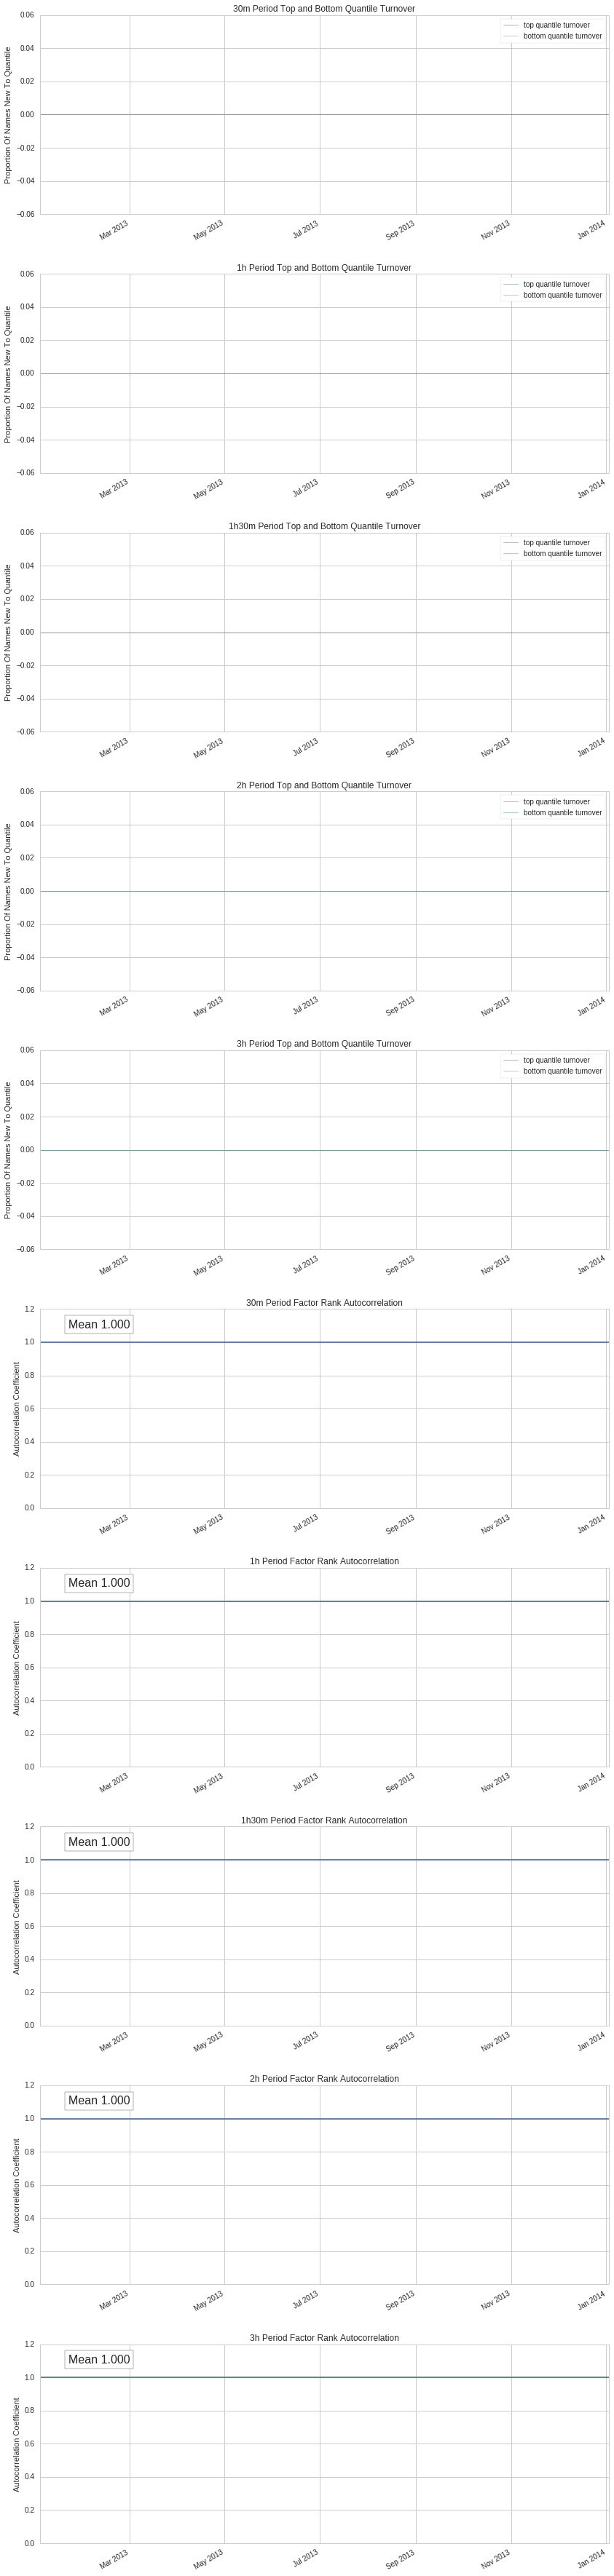

In [52]:
al.tears.create_full_tear_sheet(intraday_factor_data)

#  Event Study with Alphalens

Alphelens can also be used to perform an event study. An event study is a statistical method to assess the impact of a particular event on the value of a stock. For example we might want to evalute what happens to stocks whose price fall below 5$. While this example seems naive, there are real world trading decisions that depend on events or the events can be used as a trading strategy itself. Here are some examples of events you might want to research usign Alphalens event study:
- [Reversals During Earnings Announcements](https://www.quantopian.com/posts/quantpedia-trading-strategy-series-reversal-during-earnings-announcements)
- [Are Earnings Predictable with Buyback Announcements](https://www.quantopian.com/posts/quantpedia-trading-strategy-series-are-earnings-predictable)
- [An Empirical Algorithmic Evaluation of Technical Analysis](https://www.quantopian.com/posts/an-empirical-algorithmic-evaluation-of-technical-analysis)
- [Reversals in the PEAD](https://www.quantopian.com/posts/quantpedia-trading-strategy-series-reversals-in-the-pead)
- [Mergers and Acquisitions](https://www.quantopian.com/posts/announcing-mergers-and-acquisitions-available-through-pipeline)
- [Driven to Distraction: Extraneous Events and Underreaction to Earnings News](https://www.quantopian.com/posts/backtesting-and-discussion-of-driven-to-distraction-paper)


Some of those examples use algorithms to test their hypothesis, some others use custom NBs. Looking at  different testing methods makes clear the advantage of having a standard tool hat can be used to understand the effects of those events. This not only makes the researching process easier, but it also avoid the problem of lookahead bias, which is a all time present issue in finance. 


Let's consider the example from above, the event of a stock price falling below 5$

Alphalens calculates statistics for those dates where the input factor has values (not NaN). To compute the performace analysis on specific dates and securities (like an event study)  we have to make sure the input DataFrame contains valid values only on those date/security combinations where the event happens. All the other values in the DataFrame must be NaN or not present.

Also, make sure the event values are positive (it doesn't matter the value but they must be positive) if you intend to go long on the events and use negative values if you intent to go short. This impacts the cumulative returns plots.

Let's create the event DataFrame where we "mark" (any value) each day a security price fall below 5$.

In [53]:
class HistoricalClose(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 2
    
    def compute(self, today, assets, out, close):
        out[:] = close[0]

event_mask = (USEquityPricing.close.latest < 5) & (HistoricalClose(mask=universe, window_length=2) >= 5)

In [54]:
pipe = Pipeline(
    columns = {
            'my_event' : event_mask,
    },
    screen=event_mask
)

events = run_pipeline(pipe, '2011-01-01', '2017-01-01')

Since we computed a Pipeline filter instead of a factor the event dataframe contains only boolean values. For this reason we replace the True value with a real number, otherwise we won't be able to run Alphalens.

In [55]:
events[:] = -1.0 # as this is negative Alphalens will trade the event with short positions
events.head()

my_event
2011-01-05 00:00:00+00:00 Equity(7465 [TGB])        -1.0
                          Equity(35217 [NES])       -1.0
2011-01-10 00:00:00+00:00 Equity(34963 [CSR])       -1.0
2011-01-11 00:00:00+00:00 Equity(19773 [COCO])      -1.0
2011-01-18 00:00:00+00:00 Equity(6317 [ZQK])        -1.0

In [56]:
asset_list = events.index.levels[1].unique()

In [57]:
prices = get_pricing(asset_list, start_date='2011-01-01', end_date='2017-03-01', fields='open_price')

We want to have only one  bin/quantile. So we can either use:

```
quantiles = 1
bins      = None
```
or
```
quantiles = None
bins      = 1
```

But please note that in pandas versions before 0.20.0 there were few bugs in panda.qcut and pandas.cut that resulted in ValueError exception to be thrown when identical values were present in the dataframe and 1 quantile/bin was selected. As a workaroung use the bins custom range option that include all your values. E.g.

```
quantiles = None
bins      = [-1000,1000]
```

In [58]:
event_data = al.utils.get_clean_factor_and_forward_returns(events, 
                                                           prices, 
                                                           quantiles=None,
                                                           bins=[-10,10], # bug in pandas explained above
                                                           periods=(1, 2, 3, 4, 5, 6, 10),
                                                           filter_zscore=None)

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [59]:
event_data.head()

1D        2D        3D  \
date                      asset                                                
2011-01-05 00:00:00+00:00 Equity(7465 [TGB])   -0.012146 -0.004049  0.026316   
                          Equity(35217 [NES])   0.006061  0.034343  0.034343   
2011-01-10 00:00:00+00:00 Equity(34963 [CSR])  -0.034205 -0.024145 -0.012072   
2011-01-11 00:00:00+00:00 Equity(19773 [COCO]) -0.018789 -0.031315  0.050104   
2011-01-18 00:00:00+00:00 Equity(6317 [ZQK])   -0.010020 -0.074148 -0.078156   

                                                      4D        5D        6D  \
date                      asset                                                
2011-01-05 00:00:00+00:00 Equity(7465 [TGB])    0.093117  0.214575  0.176113   
                          Equity(35217 [NES])   0.050505  0.066667  0.088889   
2011-01-10 00:00:00+00:00 Equity(34963 [CSR])  -0.028169  0.000000 -0.024145   
2011-01-11 00:00:00+00:00 Equity(19773 [COCO])  0.062630  0.064718  0.027140   
2011-01-18 00:00:00+00:00 Equity(6317 [ZQK])   -0.118236 -0.128257 -0.098196   

                                                     10D  factor  \
date                      asset                                    
2011-01-05 00:00:00+00:00 Equity(7465 [TGB])    0.151822    -1.0   
                          Equity(35217 [NES])   0.016162    -1.0   
2011-01-10 00:00:00+00:00 Equity(34963 [CSR])  -0.010060    -1.0   
2011-01-11 00:00:00+00:00 Equity(19773 [COCO])  0.162839    -1.0   
2011-01-18 00:00:00+00:00 Equity(6317 [ZQK])   -0.094188    -1.0   

                                                factor_quantile  
date                      asset                                  
2011-01-05 00:00:00+00:00 Equity(7465 [TGB])                  1  
                          Equity(35217 [NES])                 1  
2011-01-10 00:00:00+00:00 Equity(34963 [CSR])                 1  
2011-01-11 00:00:00+00:00 Equity(19773 [COCO])                1  
2011-01-18 00:00:00+00:00 Equity(6317 [ZQK])                  1

Quantiles Statistics


min  max  mean  std  count  count %
factor_quantile                                     
1               -1.0 -1.0  -1.0  0.0   1846    100.0

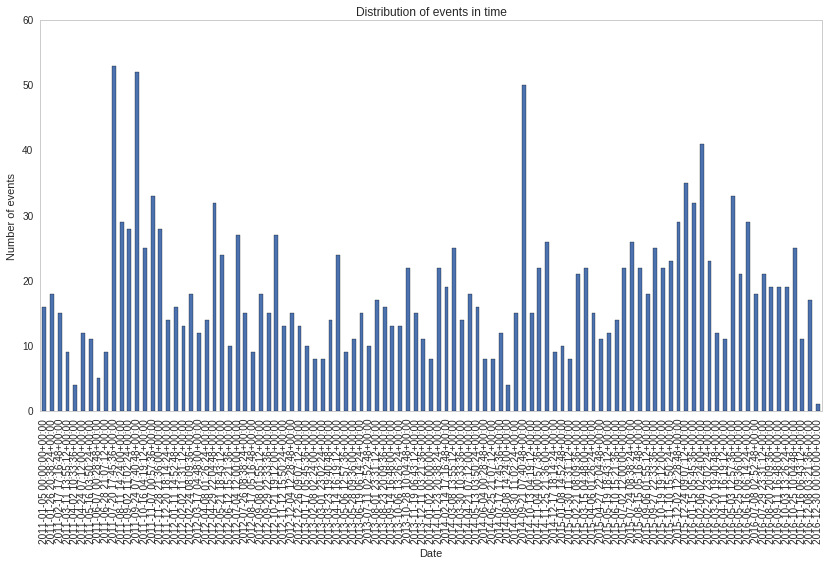

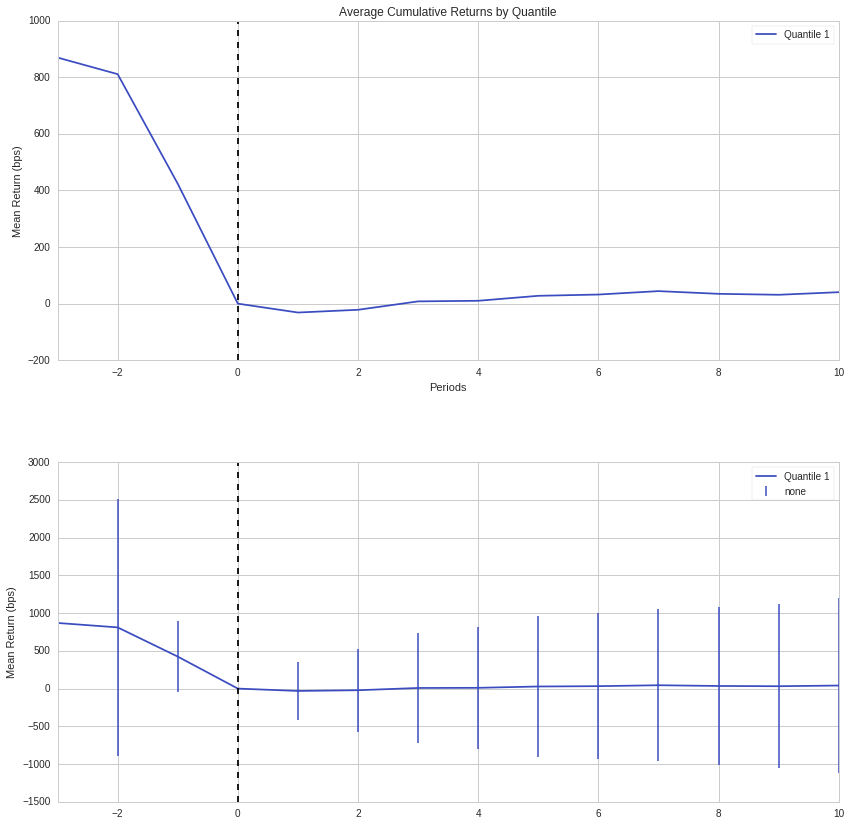

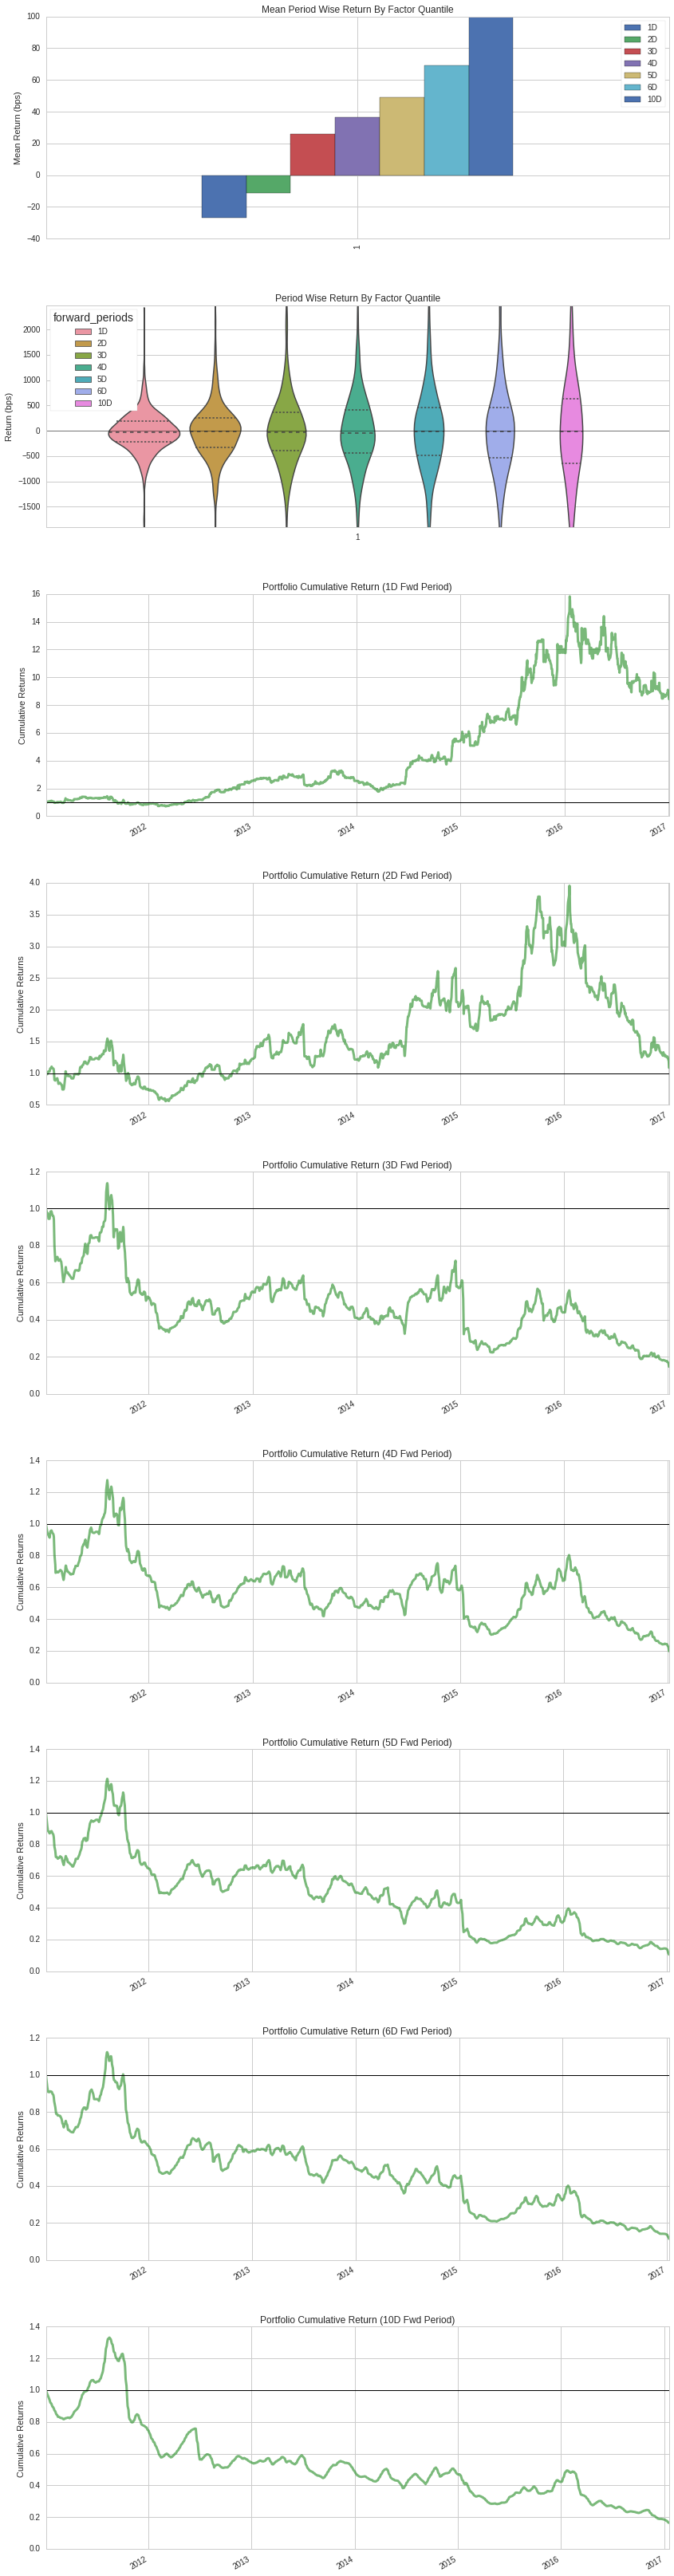

In [60]:
al.tears.create_event_study_tear_sheet(event_data,
                                       prices,
                                       avgretplot=(3, 10),
                                       rate_of_ret=False,
                                       n_bars=100)

The "Distribution of events in time" plot shows when and how many times the event happened and it is useful to detect anomalies (e.g. are the events distributed equally? Is it a cyclical event? is the event disappearing in recent times?) and to understand how often we expect to trade this signal.

The "Average Cumulative Returns by Quantile" plot shows an overview of the factor performance few days before and few days after (avgretplot=(3,10)) the factor signal and it is plot two times, the second one shows the the standard deviation of the returns. This plot is properly explained in the paragraph "Understanding Alphalens Report part 1: Event-Study-Like Return".

The "Mean Period Wise Return By Factor Quantile" plot tells us what return we would have made on average if we had held the  securities that generated the event for different time periods. This is explained in "Understanding Alphalens Report part 2: Returns Analysis". The option `rate_of_ret` allows to select between the rate of return and actual return. The rate of return allow to compare returns happening at different time frequency but it is not useful when an event doesn't happen frequently and it probably makes more sense to look at the actual return in this case.

The "Period Wise Return By Factor Quantile" violin plot show the information of the previous plot but this time we can see the full distribution of forward returns. Looking at the variance of the return distribution is useful to have a sense of how noisy the event is, that is how  confident we can be on the mean forward returns seen in the previous plot.

The "Portfolio Cumulative Return" plot is straightforward and it shows what the performance of a portfolio would be if it traded this event at different time periods.